## From Landmarks to Animations

Víctor Ubieto | 2022

victoremilio.ubieto@upf.edu // victor.ubieto@e-campus.uab.cat // victorubieto01@gmail.com

In [1]:
import os
import json
import random
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import LearningRateScheduler


Let us first read the train and test files. Data Augmentation

In [46]:
# Flags for the properties of the data
flag_mirror = True # doubles the animations
flag_transformations = False # random transformations
ratio_transformations = 0.1 # (max = 1)

project_path = "E:\Documents\Projects\Python\PycharmCurrent"
dataset_dir = "E:\Documents\Projects\Python\PycharmCurrent\Dataset"
default_dataset_dir = dataset_dir + "\Default"

# Load train data
X_train = []
os.chdir(os.path.join(default_dataset_dir, "Train"))
for file in os.listdir():
    if file.endswith(".json"):
        with open(file, 'r') as f:
            d = json.load(f) # returns JSON object as a dictionary
            X_train = X_train + d

Y_train = []
os.chdir(os.path.join(default_dataset_dir, "Train\gt"))
for file in os.listdir():
    with open(file, 'r') as f:
        d = json.load(f)
        Y_train = Y_train + d

# Load test data
x_test = []
os.chdir(os.path.join(default_dataset_dir, "Test"))
for file in os.listdir():
    if file.endswith(".json"):
        with open(file, 'r') as f:
            d = json.load(f) # returns JSON object as a dictionary
            x_test = x_test + d

y_test = []
os.chdir(os.path.join(default_dataset_dir, "Test\gt"))
for file in os.listdir():
    with open(file, 'r') as f:
        d = json.load(f)
        y_test = y_test + d

# Load validation data
x_val = []
os.chdir(os.path.join(default_dataset_dir, "Validation"))
for file in os.listdir():
    if file.endswith(".json"):
        with open(file, 'r') as f:
            d = json.load(f) # returns JSON object as a dictionary
            x_val = x_val + d

y_val = []
os.chdir(os.path.join(default_dataset_dir, "Validation\gt"))
for file in os.listdir():
    with open(file, 'r') as f:
        d = json.load(f)
        y_val = y_val + d

### Data Augmentation
if flag_mirror:
    mirror_dataset_dir = dataset_dir + "\Mirror"

    # Load train data
    os.chdir(os.path.join(mirror_dataset_dir, "Train"))
    for file in os.listdir():
        if file.endswith(".json"):
            with open(file, 'r') as f:
                d = json.load(f) # returns JSON object as a dictionary
                X_train = X_train + d

    os.chdir(os.path.join(mirror_dataset_dir, "Train\gt"))
    for file in os.listdir():
        with open(file, 'r') as f:
            d = json.load(f)
            Y_train = Y_train + d

    # Load test data
    os.chdir(os.path.join(mirror_dataset_dir, "Test"))
    for file in os.listdir():
        if file.endswith(".json"):
            with open(file, 'r') as f:
                d = json.load(f) # returns JSON object as a dictionary
                x_test = x_test + d

    os.chdir(os.path.join(mirror_dataset_dir, "Test\gt"))
    for file in os.listdir():
        with open(file, 'r') as f:
            d = json.load(f)
            y_test = y_test + d

    # Load validation data
    os.chdir(os.path.join(mirror_dataset_dir, "Validation"))
    for file in os.listdir():
        if file.endswith(".json"):
            with open(file, 'r') as f:
                d = json.load(f) # returns JSON object as a dictionary
                x_val = x_val + d

    os.chdir(os.path.join(mirror_dataset_dir, "Validation\gt"))
    for file in os.listdir():
        with open(file, 'r') as f:
            d = json.load(f)
            y_val = y_val + d

# Shuffle the data
x_train = []
y_train = []
index_shuf = list(range(len(X_train))) # list of indices
random.shuffle(index_shuf)
[x_train.append(X_train[idx]) for idx in index_shuf]
[y_train.append(Y_train[idx]) for idx in index_shuf]

if flag_transformations: # Only in training data
    aug_data_len = round(len(x_train) * ratio_transformations)
    aux_index = index_shuf[:aug_data_len] # aux list of indices of data to apply data augmentation on
    for i in aux_index:
        ## Camera Traslation in Z
        # get the data vector
        data_vec = X_train[i]
        dataGT_vec = Y_train[i]
        # map data to -1,1
        data_vec_norm = [(item * 2.0) - 1.0 for item in data_vec]
        # apply random factor between min and max zoom = [1.05, 1.72]
        scale = random.uniform(1.05, 1.73)
        data_vec_scaled = [item * scale for item in data_vec_norm]
        # return data to 0,1 (normalize again)
        aug_data = [(item + 1.0) / 2.0 for item in data_vec_scaled]
        # add the augmented data to the previous dataset
        x_train.append(aug_data)
        y_train.append(dataGT_vec)

        # Camera Traslation in X and Y
        # add or subtract a little offset in x coordinate
        # - handle it as online preprocess step -

# Check data is something
print("Total Dataset: " + str(len(x_train) + len(x_test) + len(x_val)))
print("-> Split: Train - " + str(len(x_train)) + " // Test - " + str(len(x_test)) + " // Validation - " + str(len(x_val)))
if (len(x_train) != len(y_train)) or (len(x_test) != len(y_test)) or (len(x_val) != len(y_val)):
    print("ERROR: The length of the the input data does not match the output data")

# Reset the path for saving the model later on
os.chdir(project_path)

Total Dataset: 52184
-> Split: Train - 36696 // Test - 5526 // Validation - 9962



Hyperparameters definition

In [59]:
n_epochs = 400
batch_size = 32
batch_size2 = 16
batch_size3 = 8

#def step_decay(epoch):
#   initial_lrate = 0.001
#   drop = 0.5
#   epochs_drop = 50.0
#   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#   return lrate
#lr_scheduler = LearningRateScheduler(step_decay)

lr_rate = 0.01
lr_rate2 = 0.01
decay_lr_rate = optimizers.schedules.ExponentialDecay(
     initial_learning_rate=0.02,
     decay_steps=100000,
     decay_rate=0.97)

optimizer = optimizers.SGD(learning_rate=lr_rate)
#optimizer = optimizers.Adam(learning_rate=lr_rate)
#optimizer = optimizers.Adamax(learning_rate=lr_rate)
optimizer2 = optimizers.SGD(learning_rate=lr_rate2)
optimizer3 = optimizers.SGD(learning_rate=decay_lr_rate)

quatWeights = tf.constant([ 0.5,0.5,0.5,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0,             # Hips, Spine, Spine1, Spine2
                                0.1,0.1,0.1,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,                              # Neck, Head, Head_Top
                                0.5,0.5,0.5,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0,             # (Left) Shoulder, Arm, Forearm, Hand
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Thumb1, Thumb2, Thumb3, Thumb4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Index1, Index2, Index3, Index4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Middle1, Middle2, Middle3, Middle4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Ring1, Ring2, Ring3, Ring4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Pinky1, Pinky2, Pinky3, Pinky4
                                0.5,0.5,0.5,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0,             # (Right) Shoulder, Arm, Forearm, Hand
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Right) Thumb1, Thumb2, Thumb3, Thumb4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Right) Index1, Index2, Index3, Index4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Right) Middle1, Middle2, Middle3, Middle4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Right) Ring1, Ring2, Ring3, Ring4
                                    0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0 ])           # (Right) Pinky1, Pinky2, Pinky3, Pinky4

quatWeights2 = tf.constant([ 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # Hips, Spine, Spine1, Spine2
                                0.1,0.1,0.1,0.1, 0.1,0.1,0.1,0.1, 0.1,0.1,0.1,0.1,                              # Neck, Head, Head_Top
                                1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0,             # (Left) Shoulder, Arm, Forearm, Hand
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Thumb1, Thumb2, Thumb3, Thumb4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Index1, Index2, Index3, Index4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Middle1, Middle2, Middle3, Middle4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Ring1, Ring2, Ring3, Ring4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Pinky1, Pinky2, Pinky3, Pinky4
                                1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0,             # (Right) Shoulder, Arm, Forearm, Hand
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Thumb1, Thumb2, Thumb3, Thumb4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Index1, Index2, Index3, Index4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Middle1, Middle2, Middle3, Middle4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Ring1, Ring2, Ring3, Ring4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0 ])           # (Right) Pinky1, Pinky2, Pinky3, Pinky4

quatWeights3 = tf.constant([ 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0, 0.1,0.1,0.1,1.0,             # Hips, Spine, Spine1, Spine2
                                0.1,0.1,0.1,0.5, 0.1,0.1,0.1,0.5, 0.1,0.1,0.1,0.5,                              # Neck, Head, Head_Top
                                0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Left) Shoulder, Arm, Forearm, Hand
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Thumb1, Thumb2, Thumb3, Thumb4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Index1, Index2, Index3, Index4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Middle1, Middle2, Middle3, Middle4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Ring1, Ring2, Ring3, Ring4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Left) Pinky1, Pinky2, Pinky3, Pinky4
                                0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0, 0.5,0.5,0.5,1.0,             # (Right) Shoulder, Arm, Forearm, Hand
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Thumb1, Thumb2, Thumb3, Thumb4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Index1, Index2, Index3, Index4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Middle1, Middle2, Middle3, Middle4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0,             # (Right) Ring1, Ring2, Ring3, Ring4
                                     0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0, 0.2,0.2,0.2,1.0 ])           # (Right) Pinky1, Pinky2, Pinky3, Pinky4

def custom_loss_wrapper( weights ):
    def loss( y_true, y_pred ):
        sum_weights = tf.reduce_sum(weights) * tf.cast(tf.shape(y_pred)[0], tf.float32)
        resid = tf.reduce_sum(weights * tf.square(y_true - y_pred))
        return resid/sum_weights
    return loss

#callbacks_list = [lr_scheduler]


Data preparation + data preprocessing
Divide data in train-val-test

In [6]:
## Unused now ##
#from sklearn.model_selection import train_test_split
# X_train, x_test, Y_train, y_test = train_test_split(data, gt_data, test_size=0.2)
# x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2


Model creation (https://www.tensorflow.org/tutorials/keras/regression)

In [86]:
"""
model4 = Sequential()
model4.add(layers.LayerNormalization(input_dim=len(x_train[0])))
model4.add(layers.Dense(1024, activation="relu", name="layer1"))
model4.add(layers.Dense(1024, activation="relu", name="layer2"))
model4.add(layers.Dense(len(y_train[0]), activation='linear', name="layer_out"))

model4.compile(loss=custom_loss_wrapper(quatWeights), optimizer=optimizer, metrics=['accuracy'])
model4.summary()
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

model5 = Sequential()
model5.add(layers.LayerNormalization(input_dim=len(x_train[0])))
model5.add(layers.Dense(1024, activation="relu", name="layer1"))
model5.add(layers.Dense(len(y_train[0]), activation='linear', name="layer_out"))
model5.compile(loss=custom_loss_wrapper(quatWeights2), optimizer=optimizer, metrics=['accuracy'])
"""
model7 = Sequential()
model7.add(layers.LayerNormalization(input_dim=len(x_train[0])))
model7.add(layers.Dense(1024, activation="relu", name="layer1"))
model7.add(layers.Dense(1024, activation="relu", name="layer2"))
model7.add(layers.Dense(len(y_train[0]), activation='linear', name="layer_out"))
model7.compile(loss=custom_loss_wrapper(quatWeights3), optimizer=optimizer, metrics=['accuracy'])


Training step

In [87]:
history7 = model7.fit(x_train, y_train,
                batch_size=batch_size2,
                epochs=n_epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks_list
                )
"""
history5 = model5.fit(x_train, y_train,
                batch_size=batch_size2,
                epochs=n_epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks_list
                )

history6 = model6.fit(x_train, y_train,
                batch_size=batch_size2,
                epochs=n_epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks_list
                )
"""

Epoch 1/400
2294/2294 [==============================] - 24s 10ms/step - loss: 0.0227 - accuracy: 0.0998 - val_loss: 0.0112 - val_accuracy: 0.1171
Epoch 2/400
2294/2294 [==============================] - 11s 5ms/step - loss: 0.0091 - accuracy: 0.1172 - val_loss: 0.0100 - val_accuracy: 0.1354
Epoch 3/400
2294/2294 [==============================] - 10s 5ms/step - loss: 0.0082 - accuracy: 0.1129 - val_loss: 0.0095 - val_accuracy: 0.1537
Epoch 4/400
2294/2294 [==============================] - 11s 5ms/step - loss: 0.0077 - accuracy: 0.1191 - val_loss: 0.0092 - val_accuracy: 0.1094
Epoch 5/400
2294/2294 [==============================] - 11s 5ms/step - loss: 0.0074 - accuracy: 0.1259 - val_loss: 0.0090 - val_accuracy: 0.1395
Epoch 6/400
2294/2294 [==============================] - 10s 5ms/step - loss: 0.0072 - accuracy: 0.1306 - val_loss: 0.0088 - val_accuracy: 0.1413
Epoch 7/400
2294/2294 [==============================] - 10s 5ms/step - loss: 0.0070 - accuracy: 0.1274 - val_loss: 0.0087 

KeyboardInterrupt: 


Loss Evaluation

Train Data - Loss: 0.00296     Validation Data - Loss: 0.00583     Test Data - Loss: 0.00531


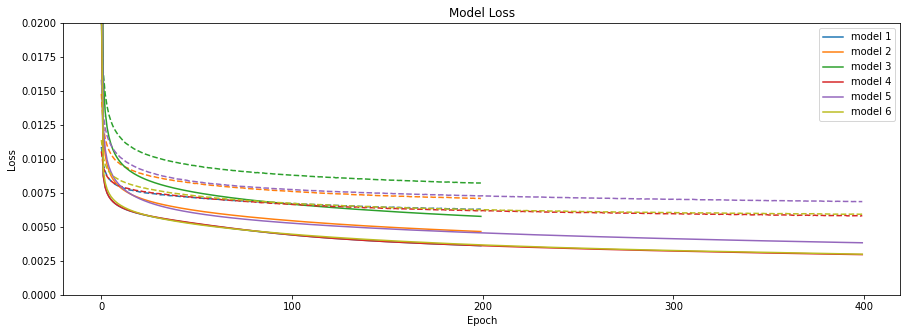

Epochs: 400    Batch Size: 32    Optimitzer: SGD    LR: 0.01


In [64]:
model4eval = model4 # in case we are training several modules

train_mse = model4eval.evaluate(x_train, y_train, verbose=0)
val_mse = model4eval.evaluate(x_val, y_val, verbose=0)
test_mse = model4eval.evaluate(x_test, y_test, verbose=0)
print('Train Data - Loss: %.5f' % train_mse[0] + '     Validation Data - Loss: %.5f' % val_mse[0] + '     Test Data - Loss: %.5f' % test_mse[0])
#'    Accuracy: %.2f' % (train_mse[1]*100)

# Plots
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

# Summarize history for accuracy
# ax2.plot(history.history['accuracy'])
# ax2.plot(history.history['val_accuracy'])
# ax2.title.set_text('model accuracy')
# ax2.set_ylabel('accuracy')
# ax2.set_xlabel('epoch')
# ax2.legend(['train', 'validation'], loc='upper left')

# Summarize history for loss
ax1.plot(history.history['loss'], color='#1f77b4', label='model 1')
ax1.plot(history.history['val_loss'], '--', color='#1f77b4', label='_nolegend_')
ax1.title.set_text('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(history2.history['loss'], color='#ff7f0e', label='model 2')
ax1.plot(history2.history['val_loss'], '--', color='#ff7f0e', label='_nolegend_')
ax1.plot(history3.history['loss'], color='#2ca02c', label='model 3')
ax1.plot(history3.history['val_loss'], '--', color='#2ca02c', label='_nolegend_')
ax1.plot(history4.history['loss'], color='#d62728', label='model 4')
ax1.plot(history4.history['val_loss'], '--', color='#d62728', label='_nolegend_')
ax1.plot(history5.history['loss'], color='#9467bd', label='model 5')
ax1.plot(history5.history['val_loss'], '--', color='#9467bd', label='_nolegend_')
ax1.plot(history6.history['loss'], color='#bcbd22', label='model 6')
ax1.plot(history6.history['val_loss'], '--', color='#bcbd22', label='_nolegend_')

plt.ylim([0, 0.02])
plt.locator_params(axis='x', nbins=8)
plt.legend(loc='upper right')
plt.show()
name = project_path + '\Loss_' + str(optimizer._name) + '_' + str(batch_size) + '.pdf'
fig.savefig(name , bbox_inches='tight')
plt.close()

print('Epochs: ' + str(n_epochs) + '    Batch Size: ' + str(batch_size) + '    Optimitzer: ' + str(optimizer._name) + '    LR: ' + str(lr_rate))


Store/Load the Model

In [72]:
filepath = project_path + "\Models\saved_model_15"
model4save = model5

os.makedirs(project_path + "\Models", exist_ok=True)
# Save the model
model4save.save(filepath)

# Save the model serialized to JSON
tfjs.converters.save_keras_model(model4save, os.path.join(filepath, "TensorflowJS_model"))
model_json = model4save.to_json()
with open(os.path.join(filepath, "TensorflowJS_model", "auxiliar_model.json"), "w") as json_file:
    json_file.write(model_json)

# save configuration of the model
with open(os.path.join(filepath, 'Model Configuration.txt'), 'w') as f:
    f.write('Test Loss: %.5f' % test_mse[0] + '    Epochs: ' + str(n_epochs) + '    Batch Size: ' + str(batch_size) + '    Optimitzer: ' + str(optimizer._name))

INFO:tensorflow:Assets written to: E:\Documents\Projects\Python\PycharmCurrent\Models\saved_model_13\assets


In [9]:
filepath = project_path + "\Models\saved_model_10"

# Load the mode
model = load_model(filepath, compile = True)

ValueError: Unknown loss function: loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


Prediction test

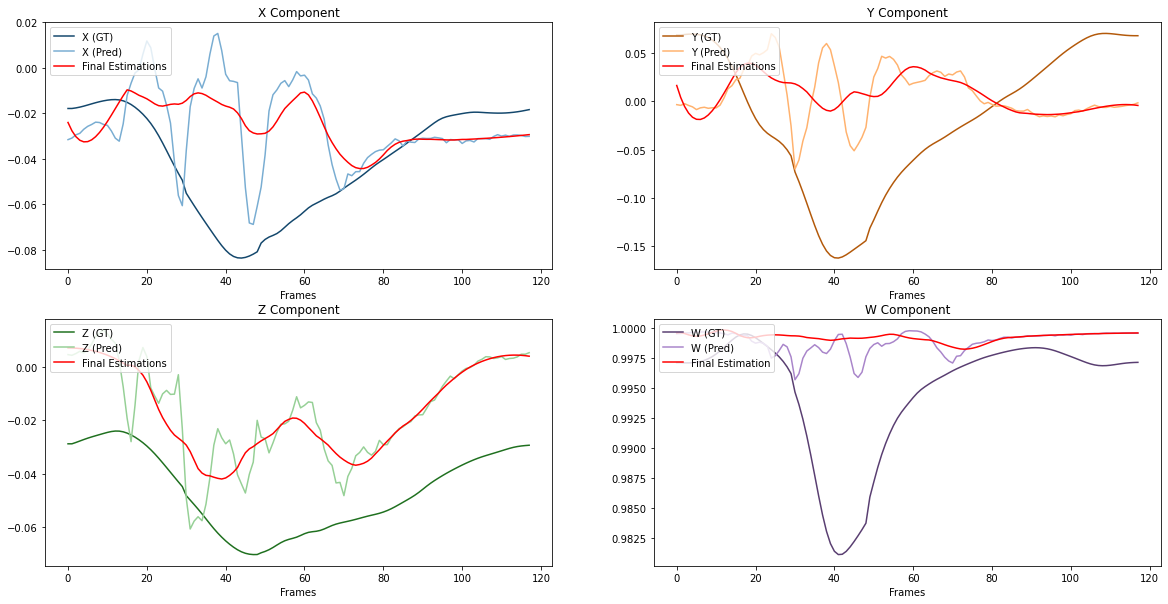

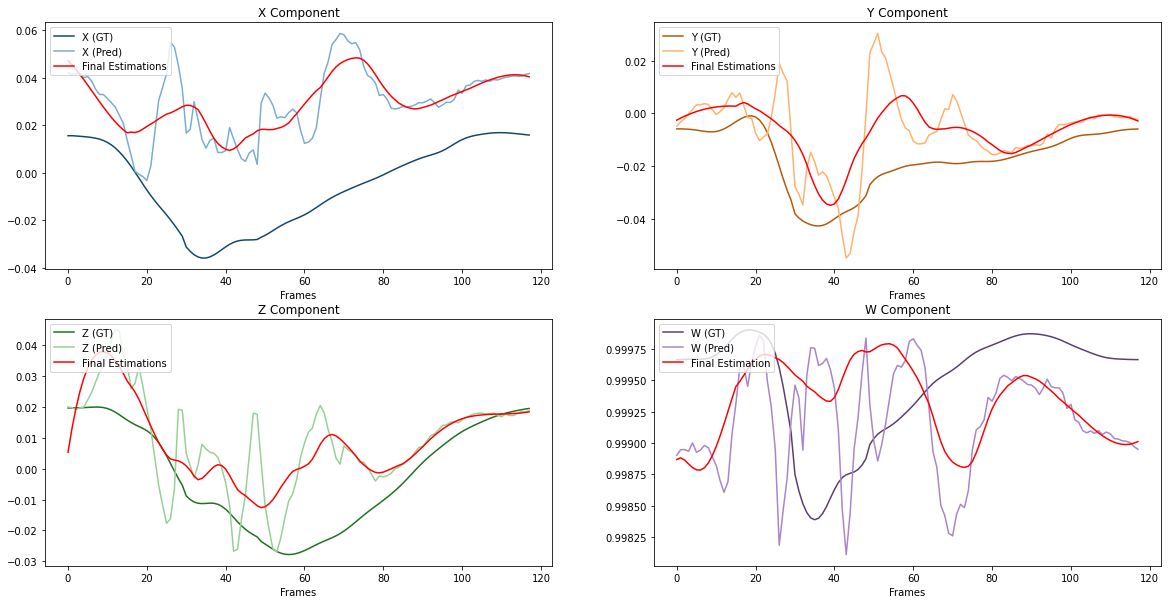

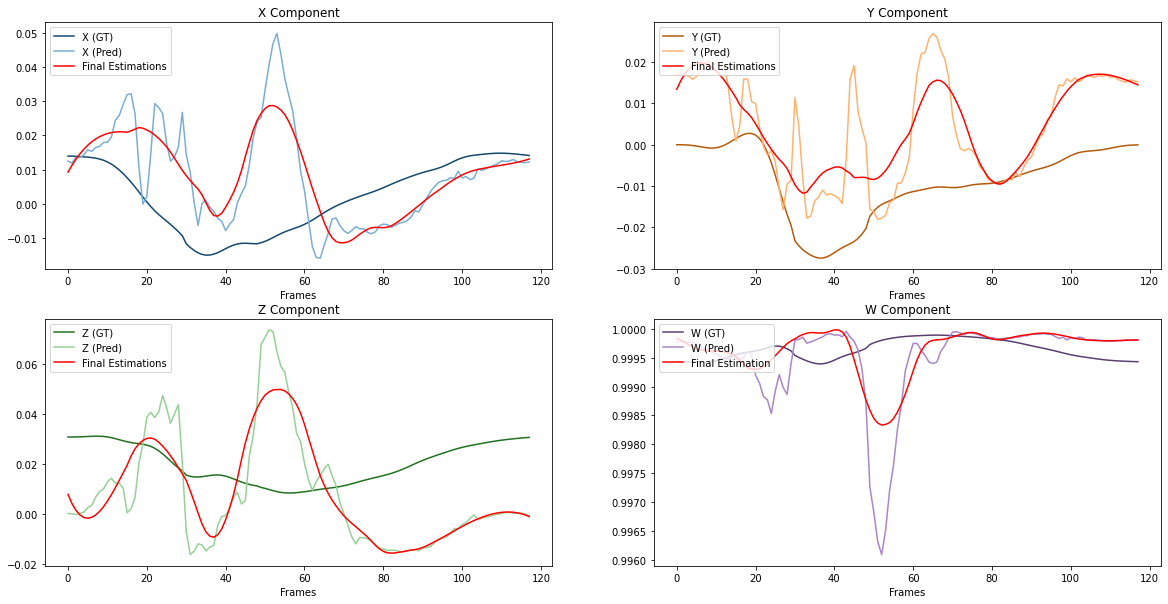

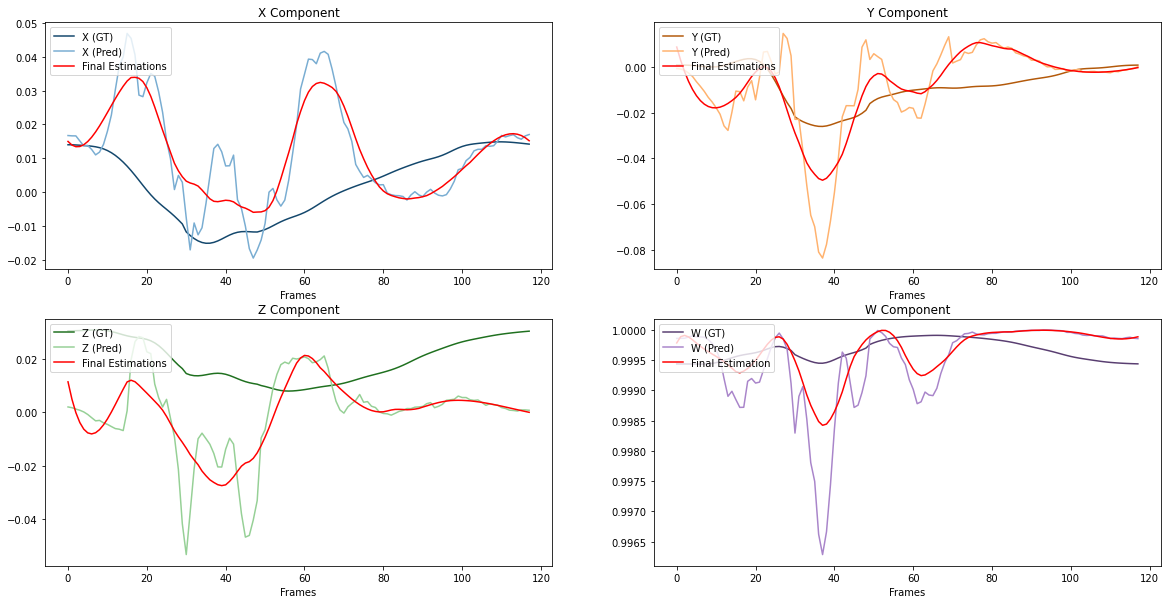

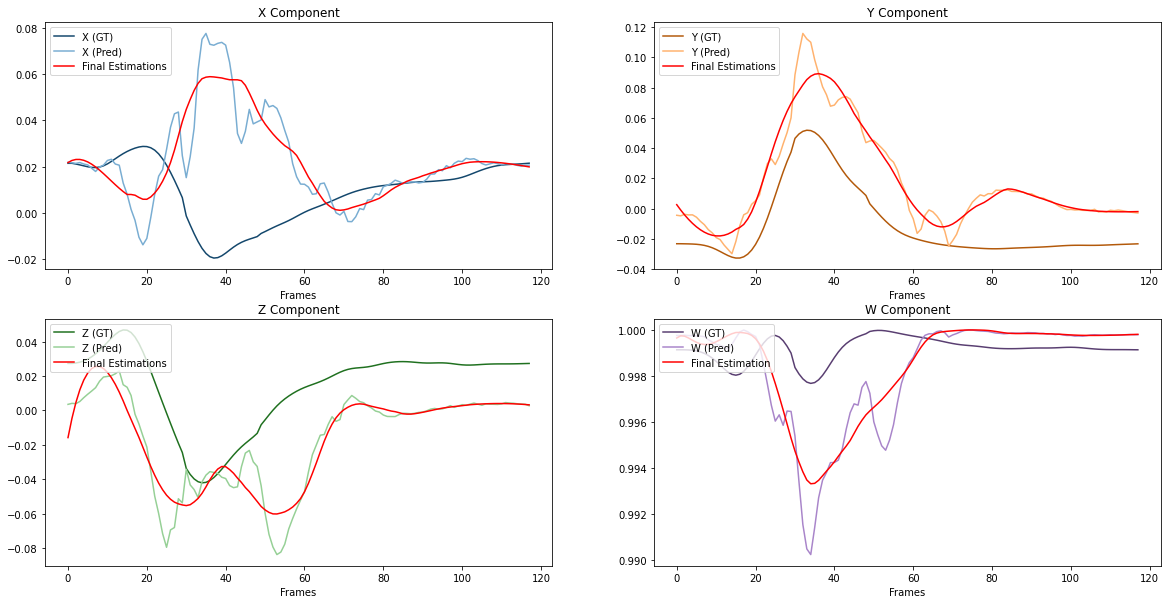

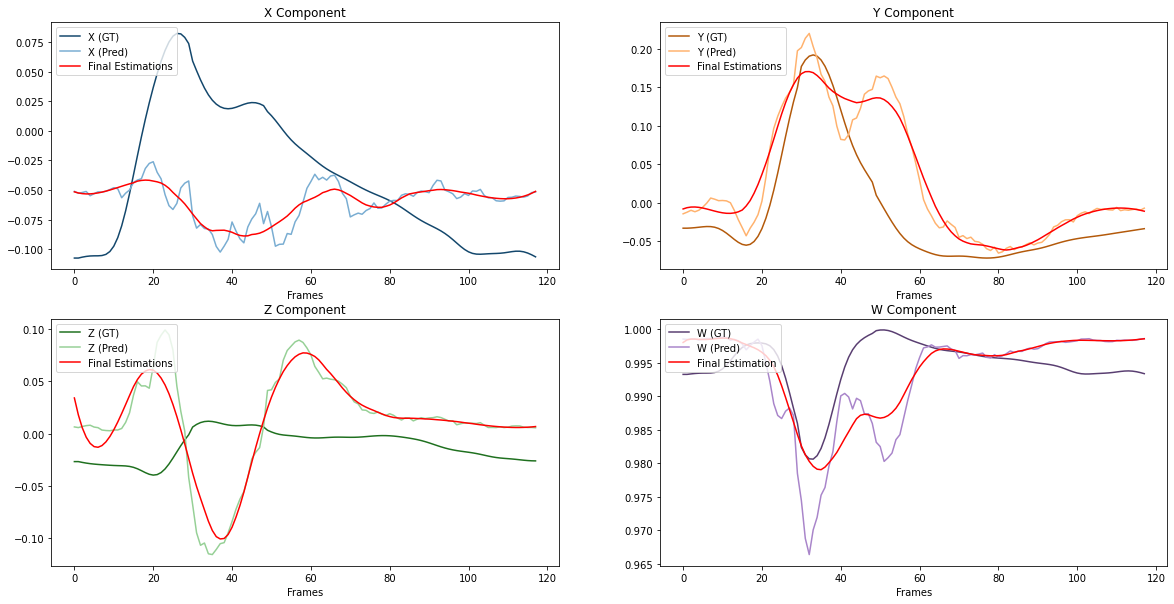

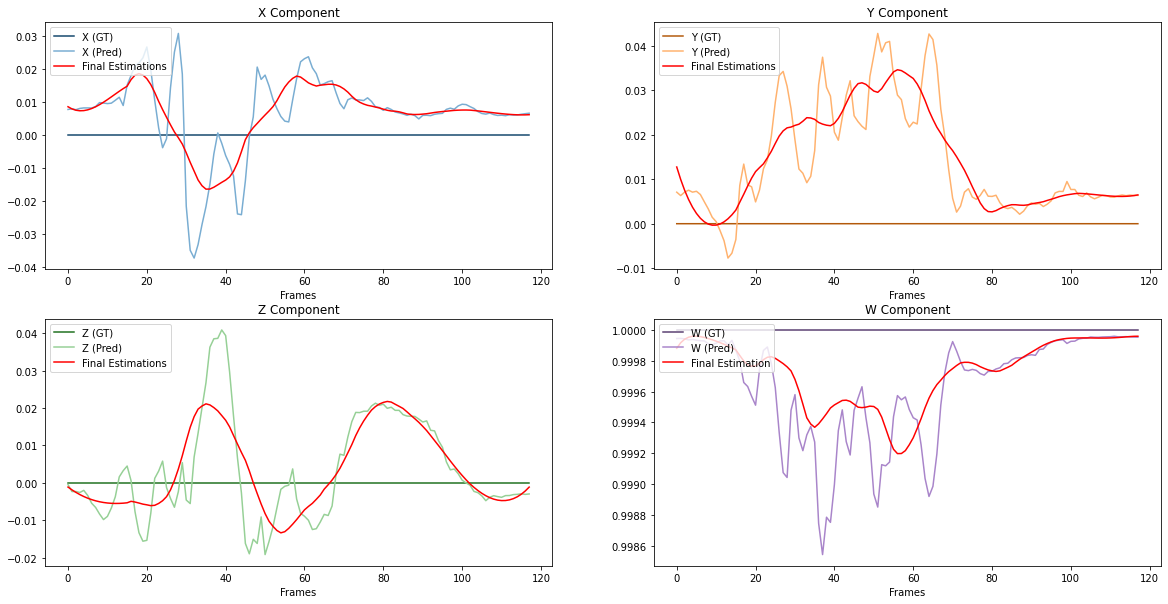

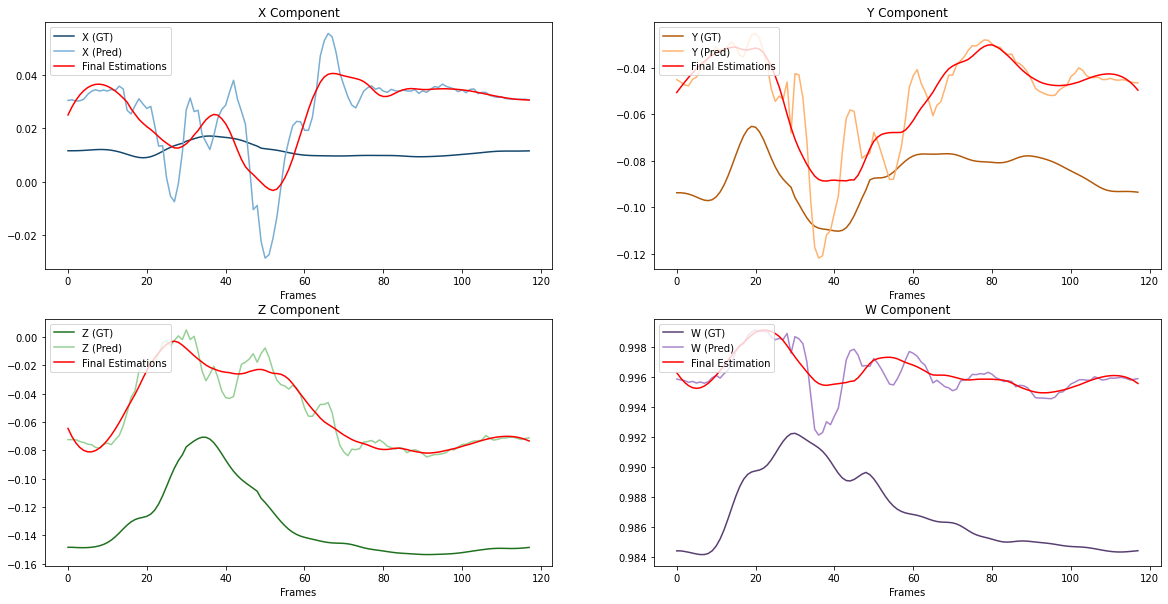

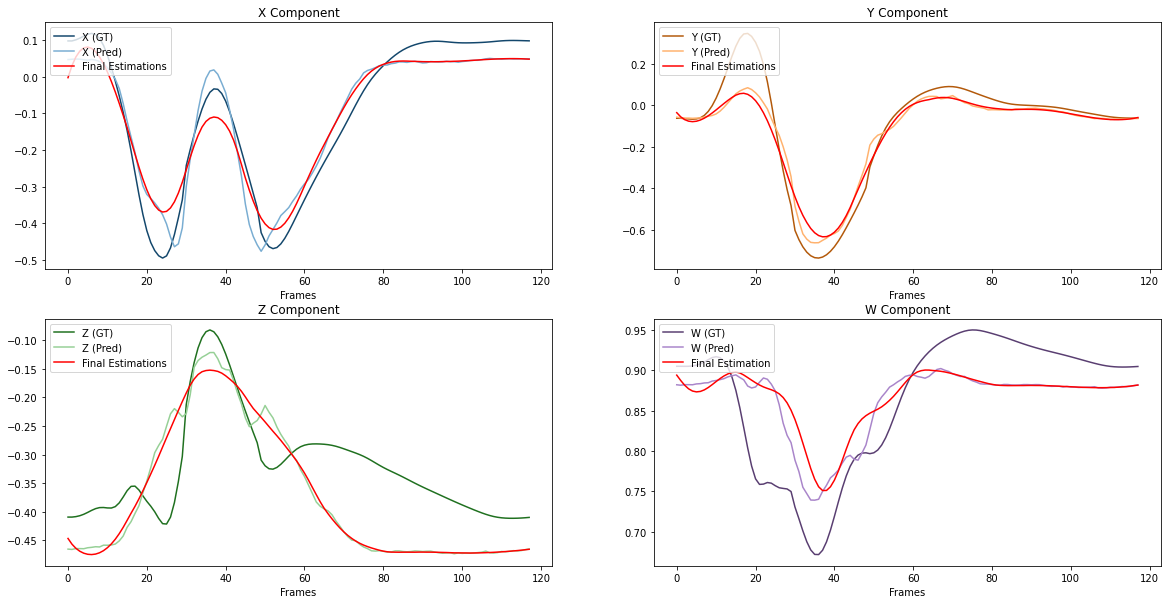

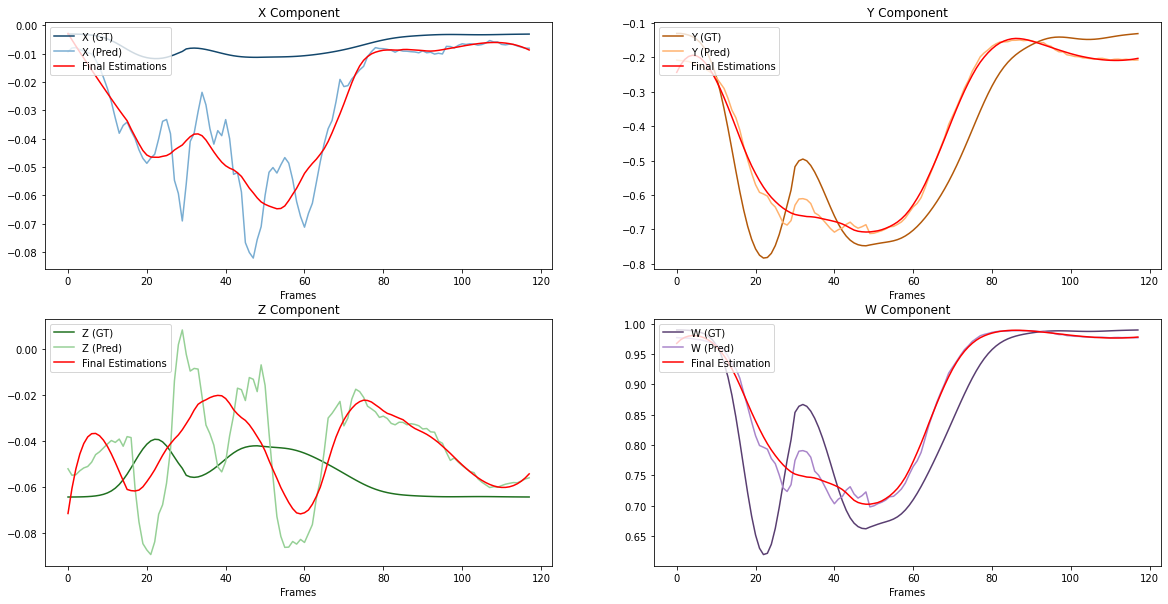

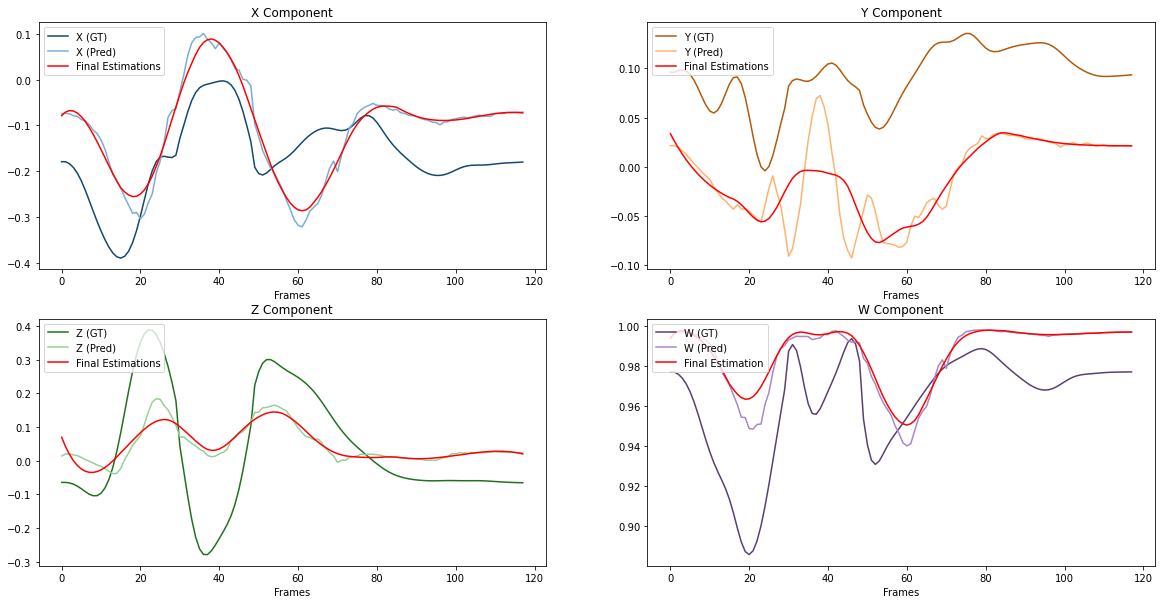

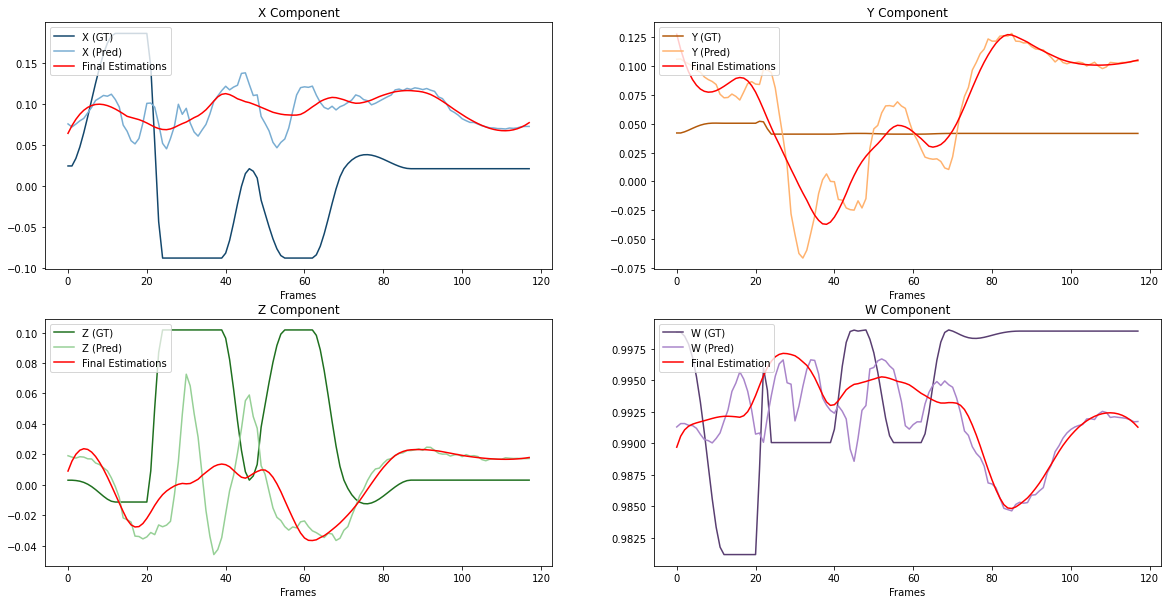

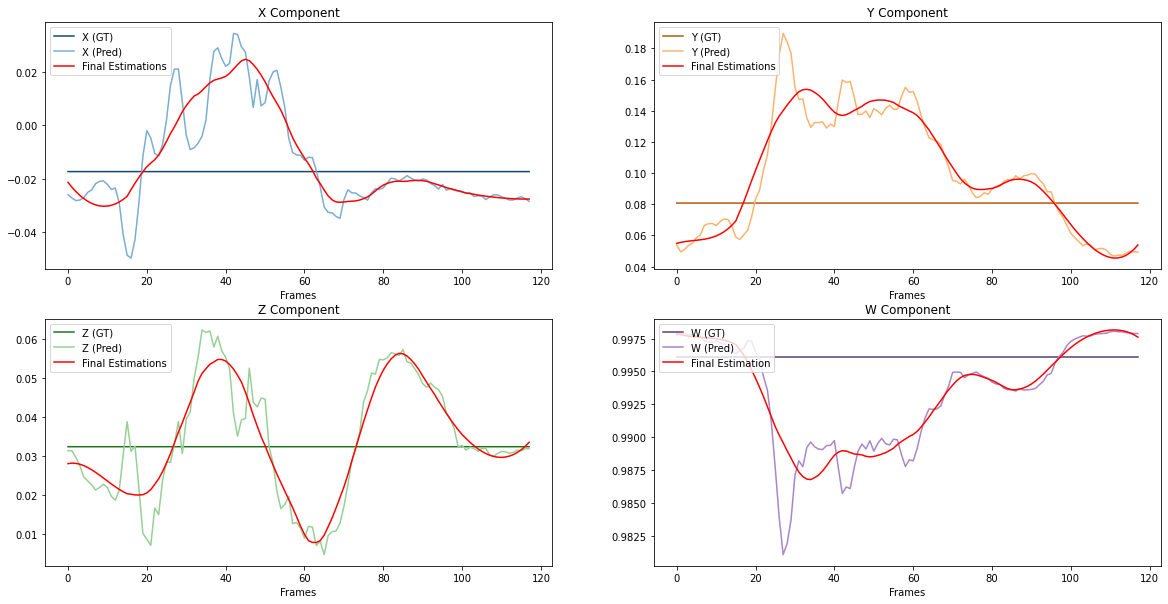

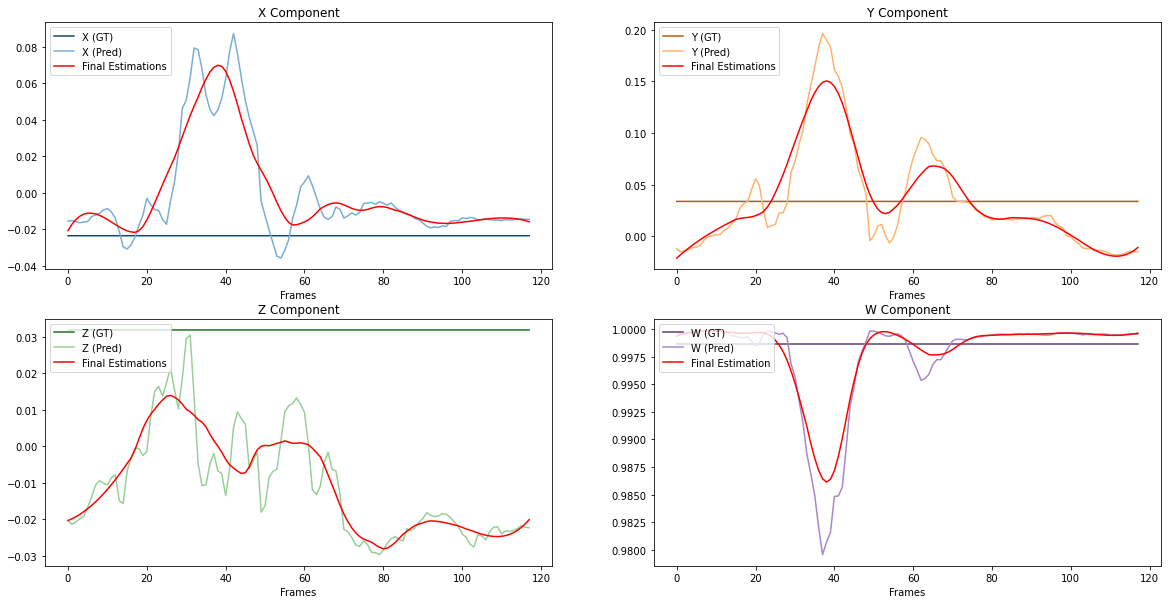

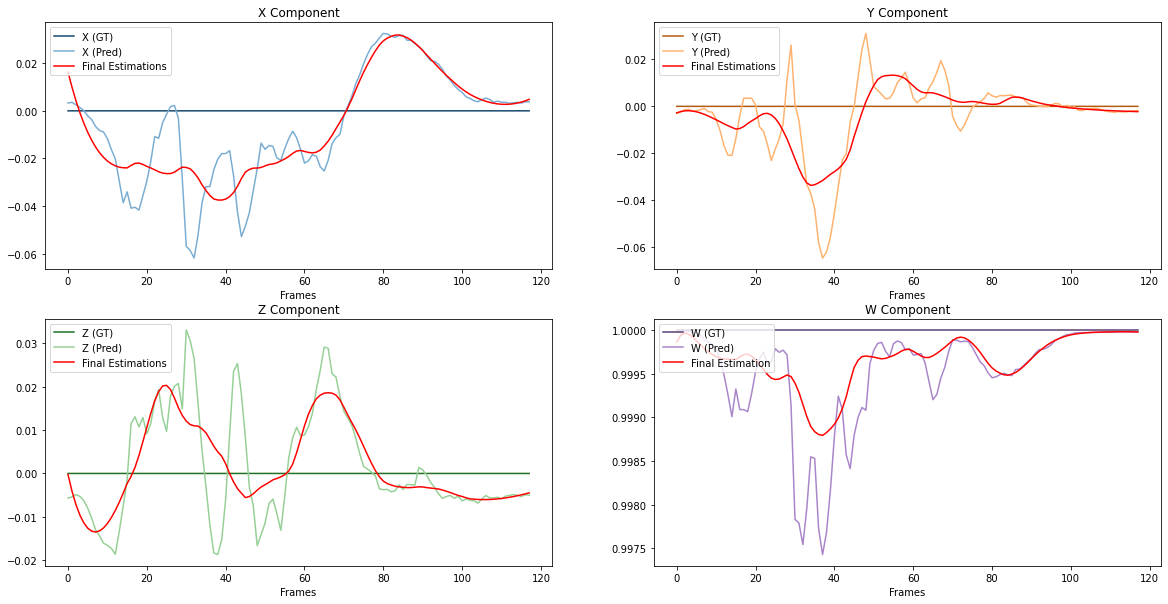

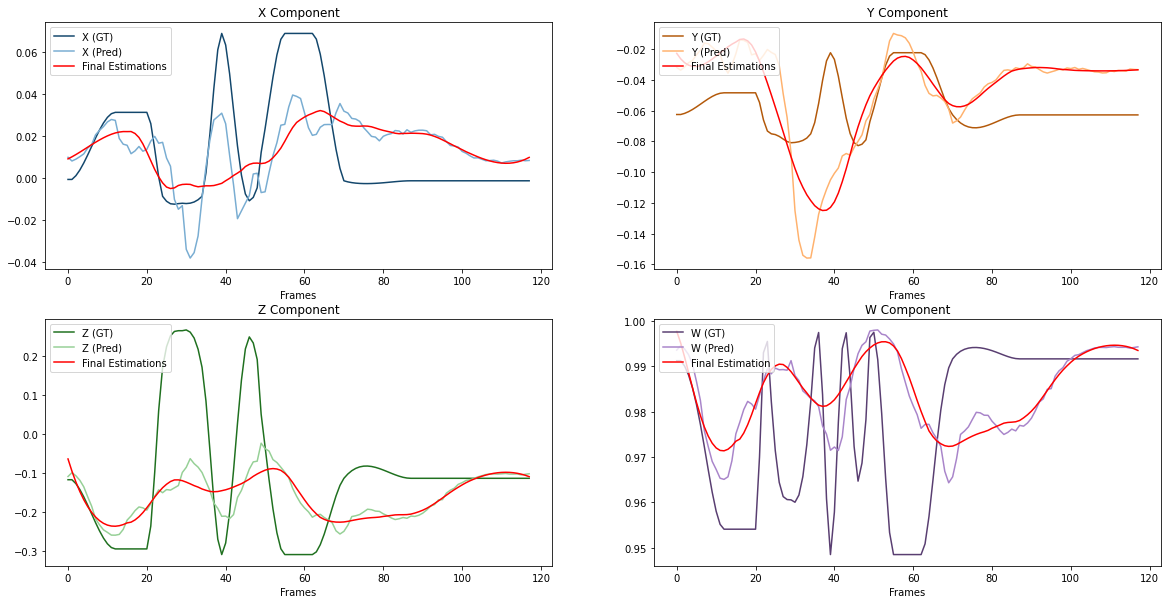

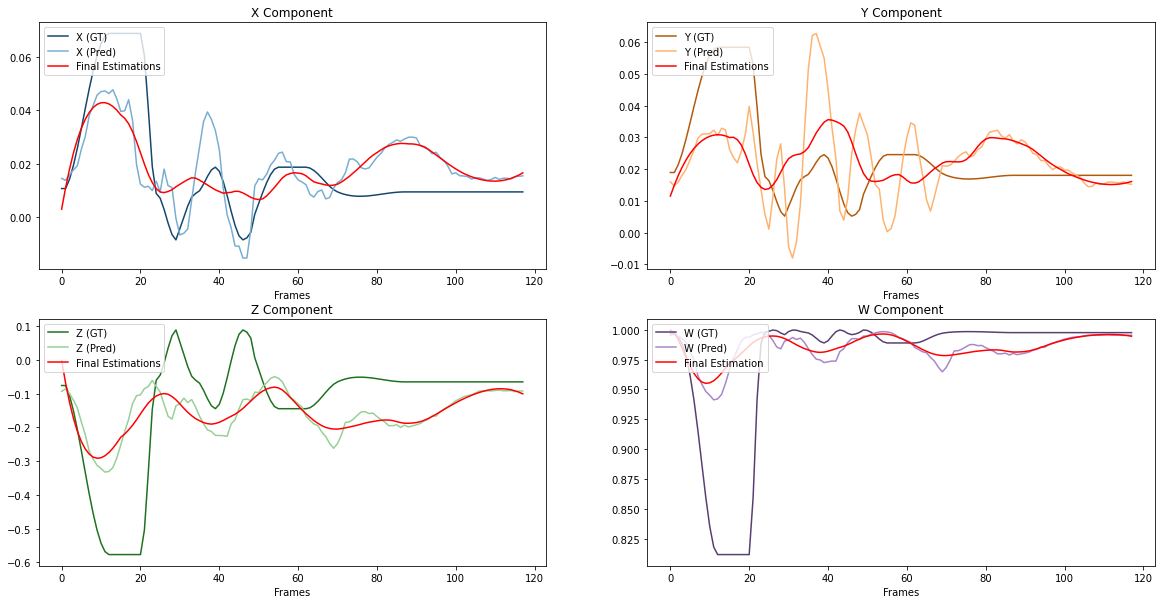

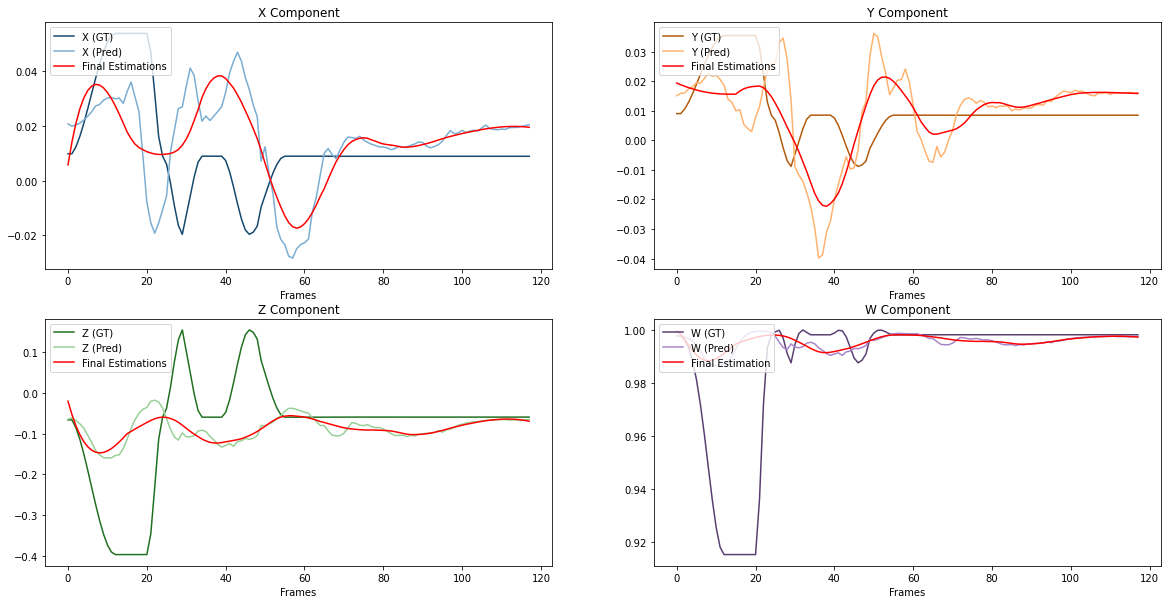

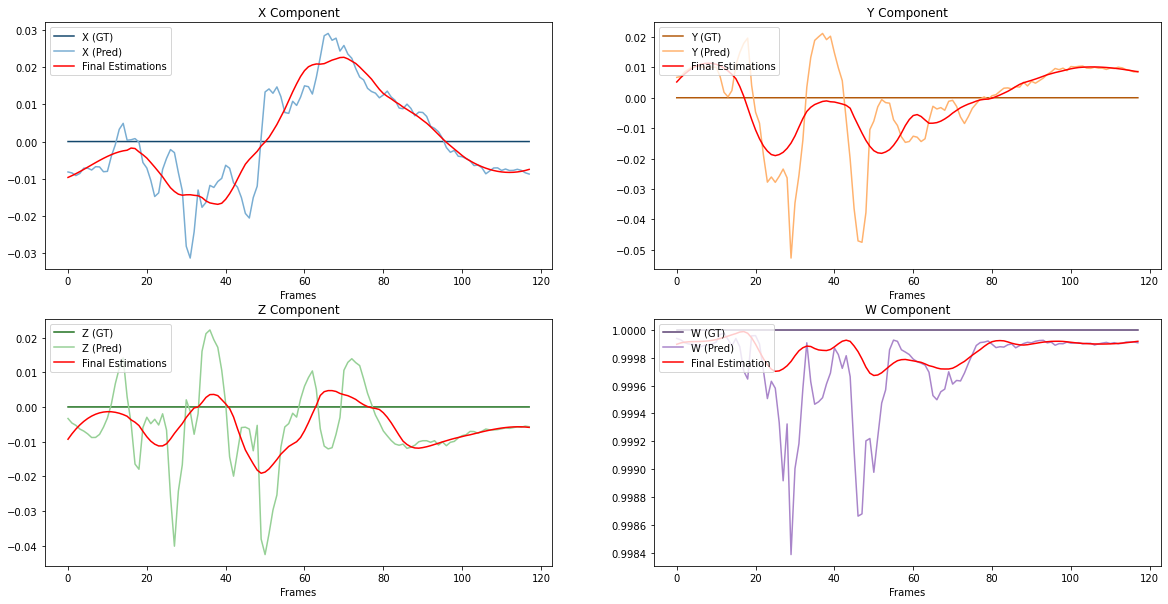

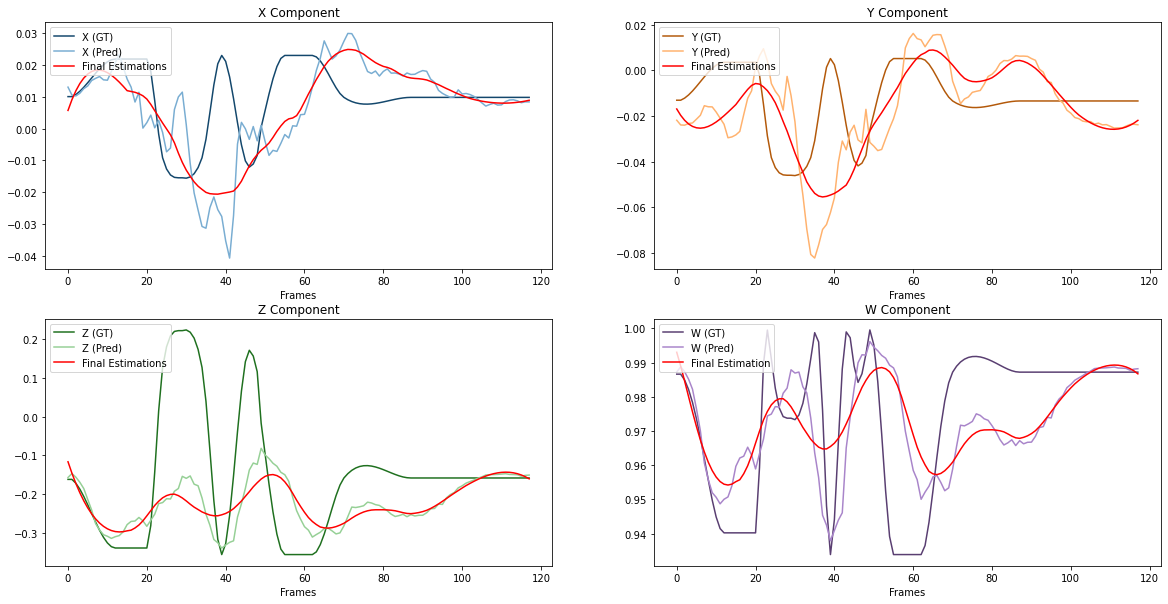

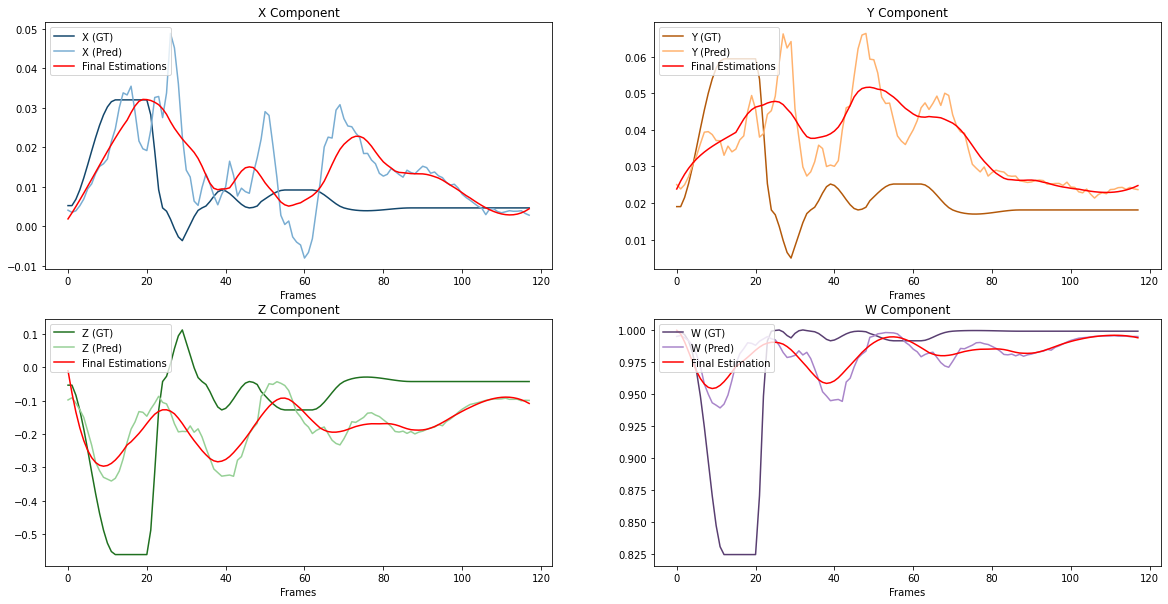

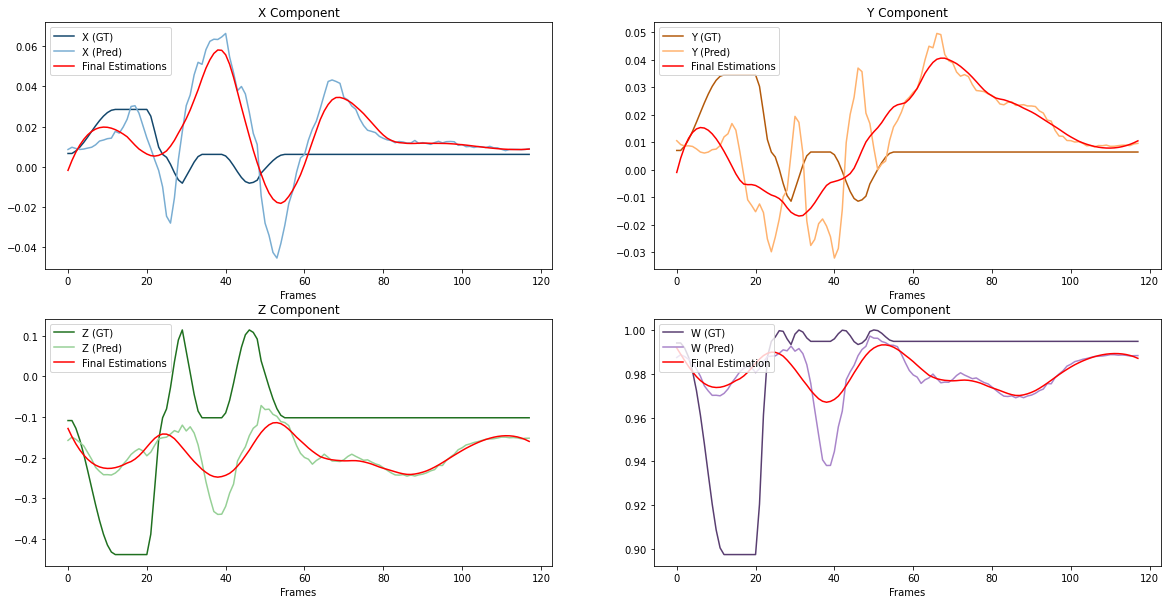

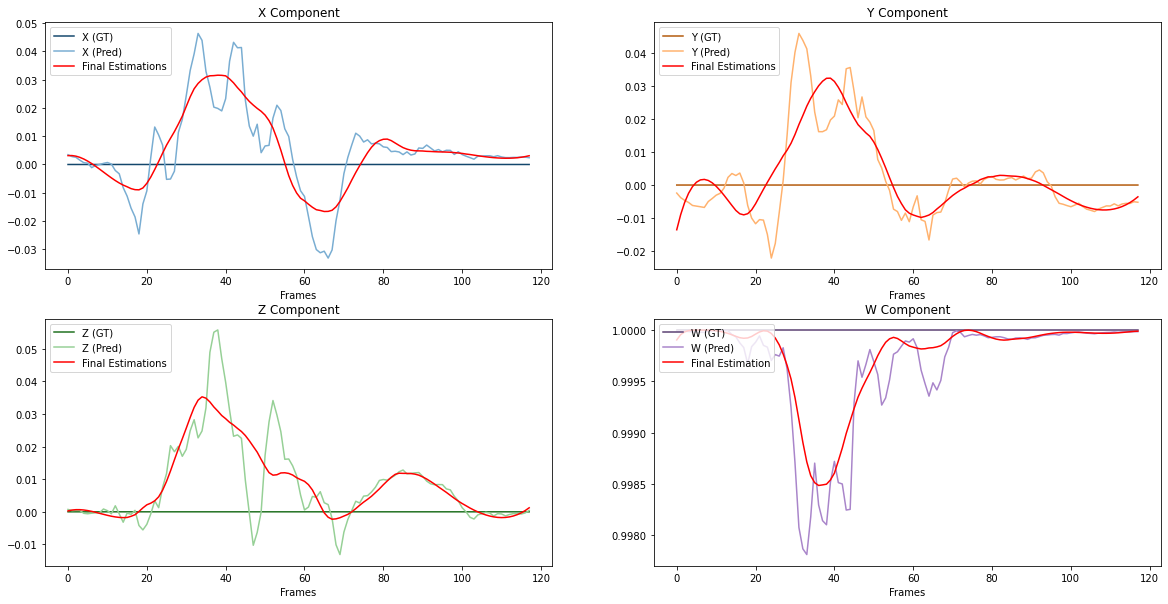

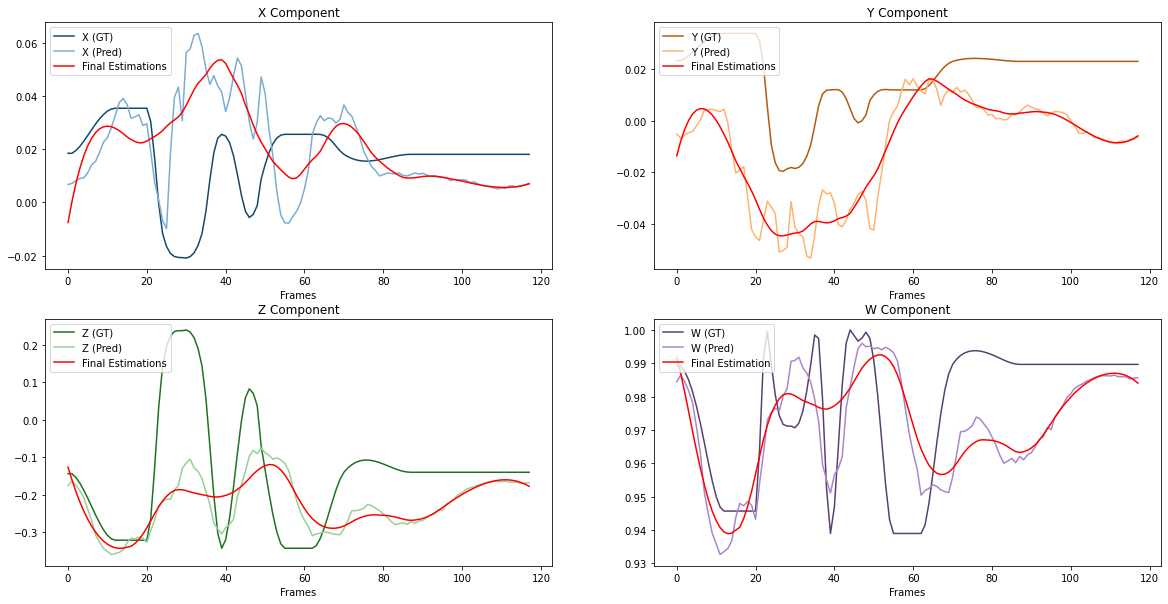

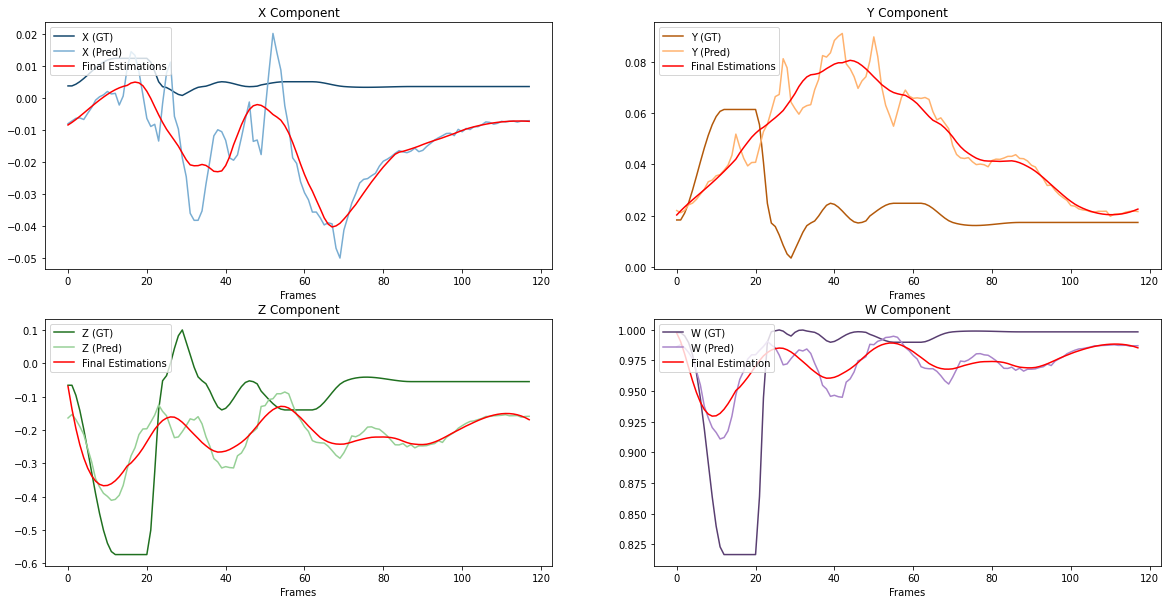

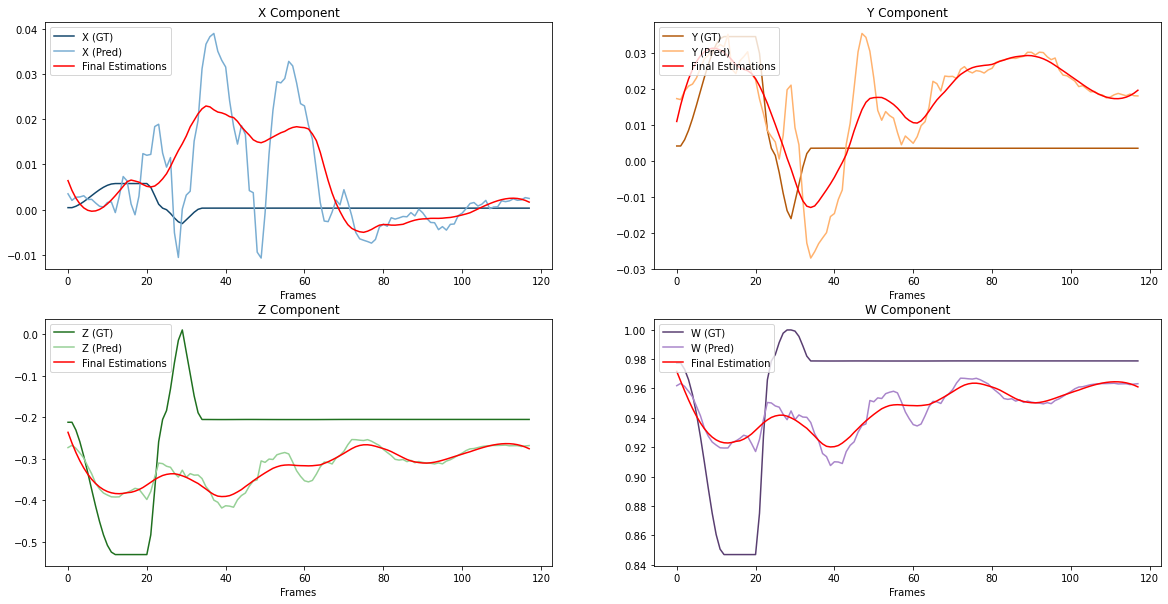

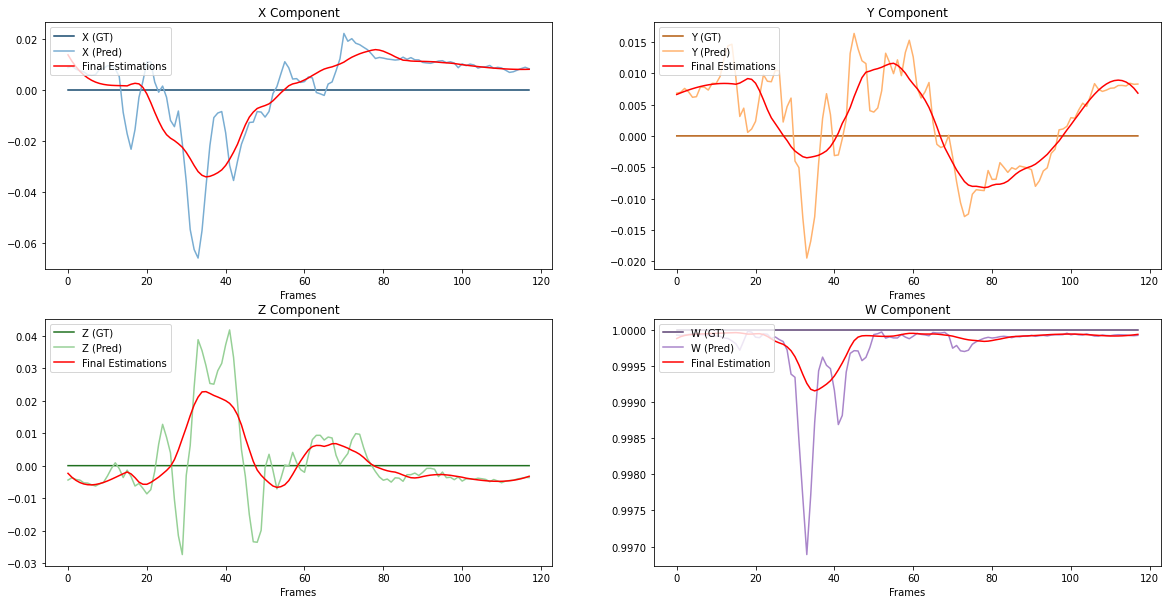

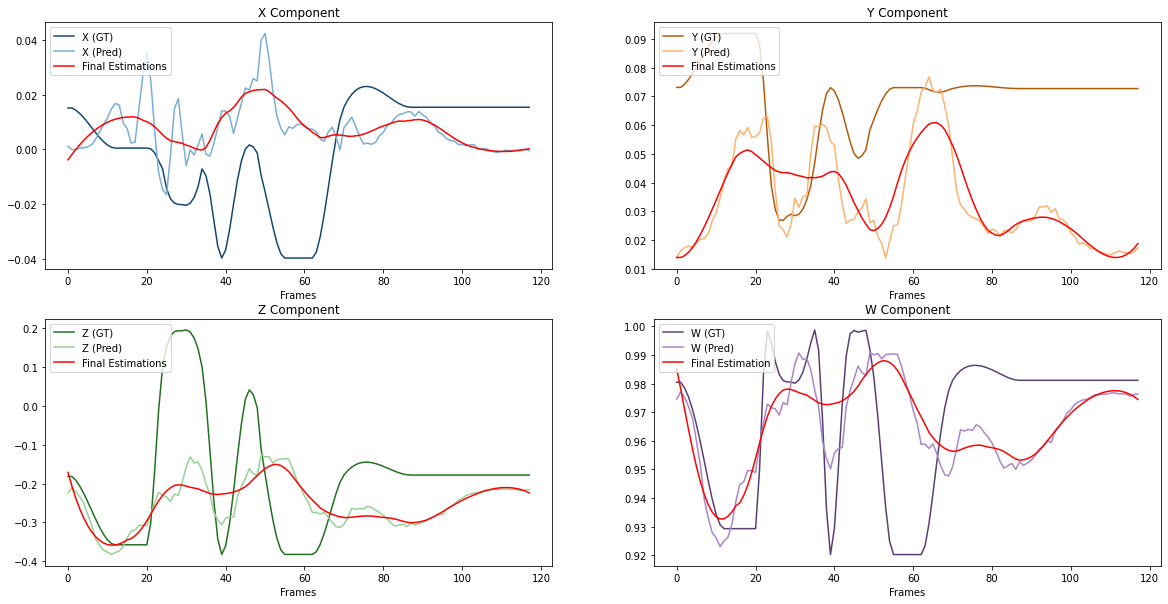

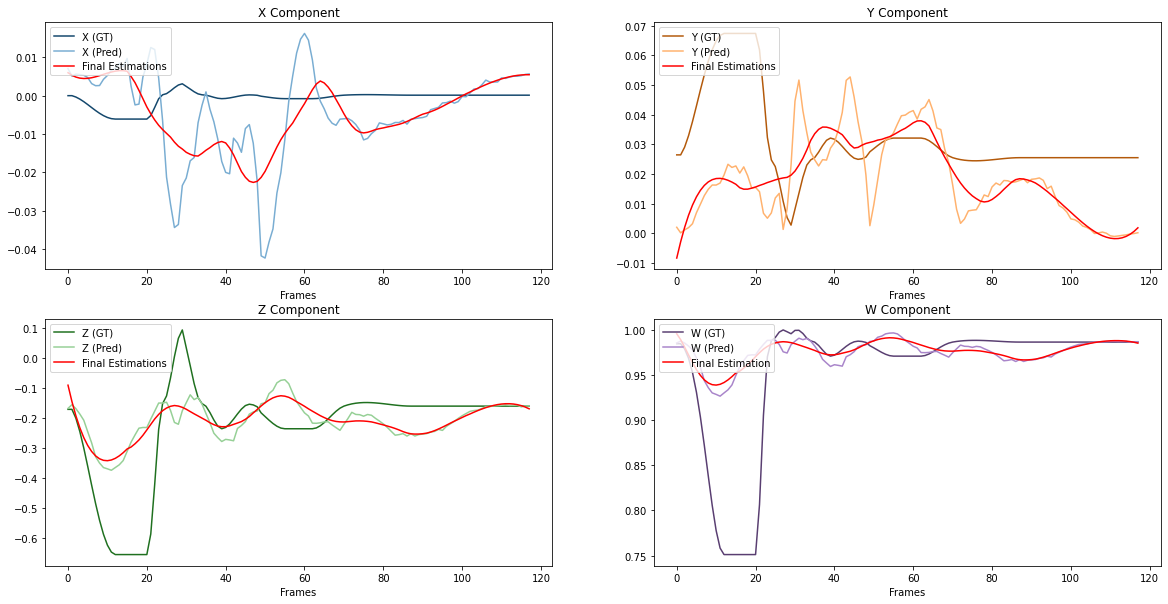

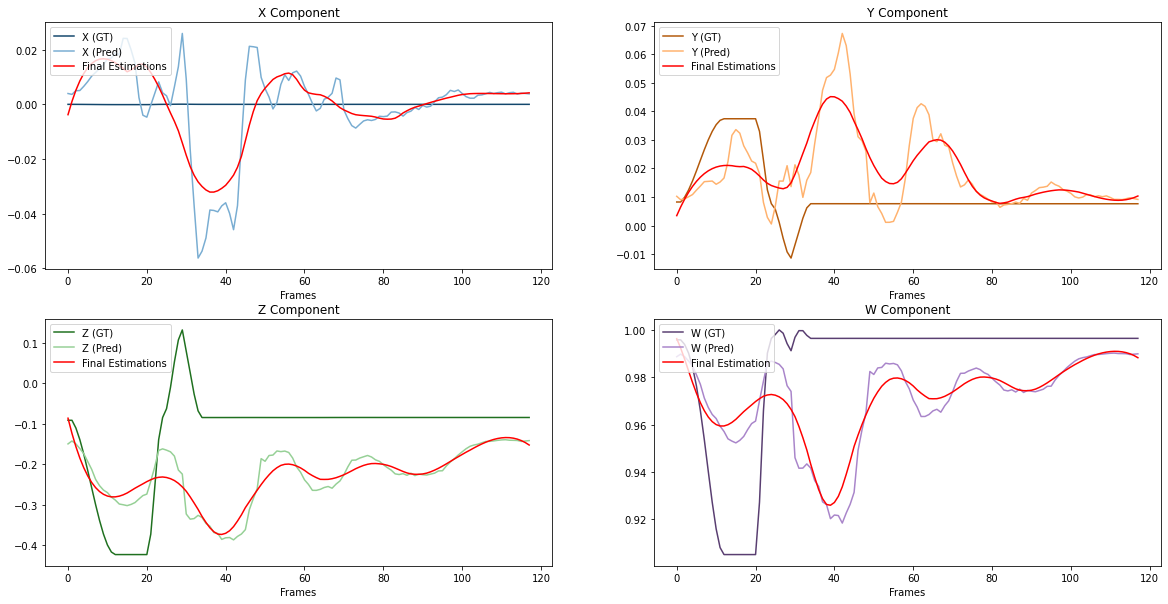

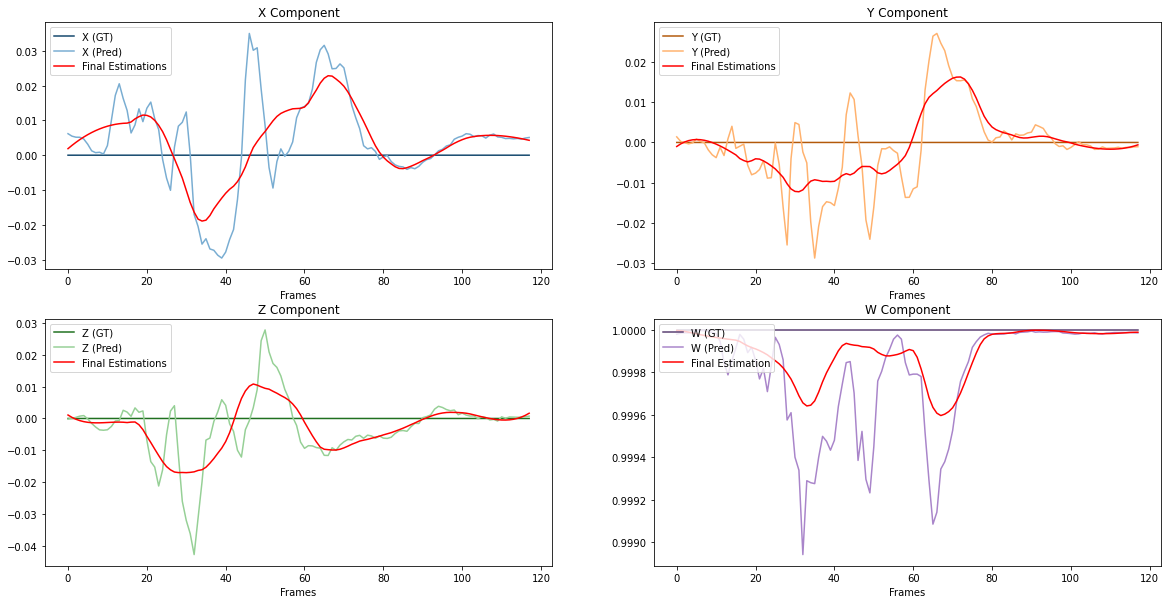

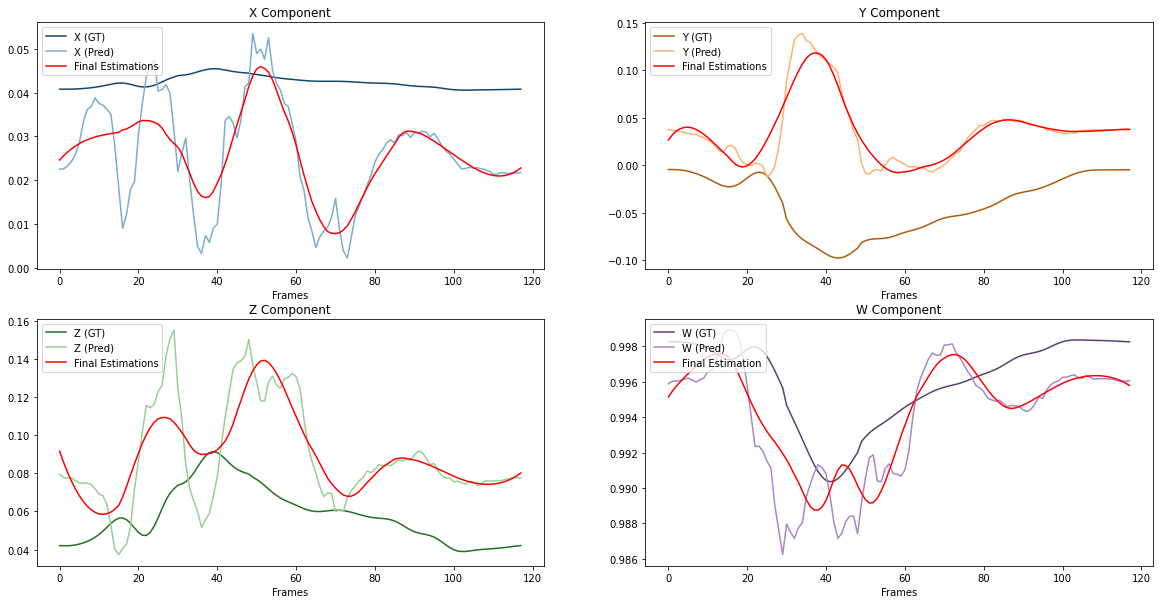

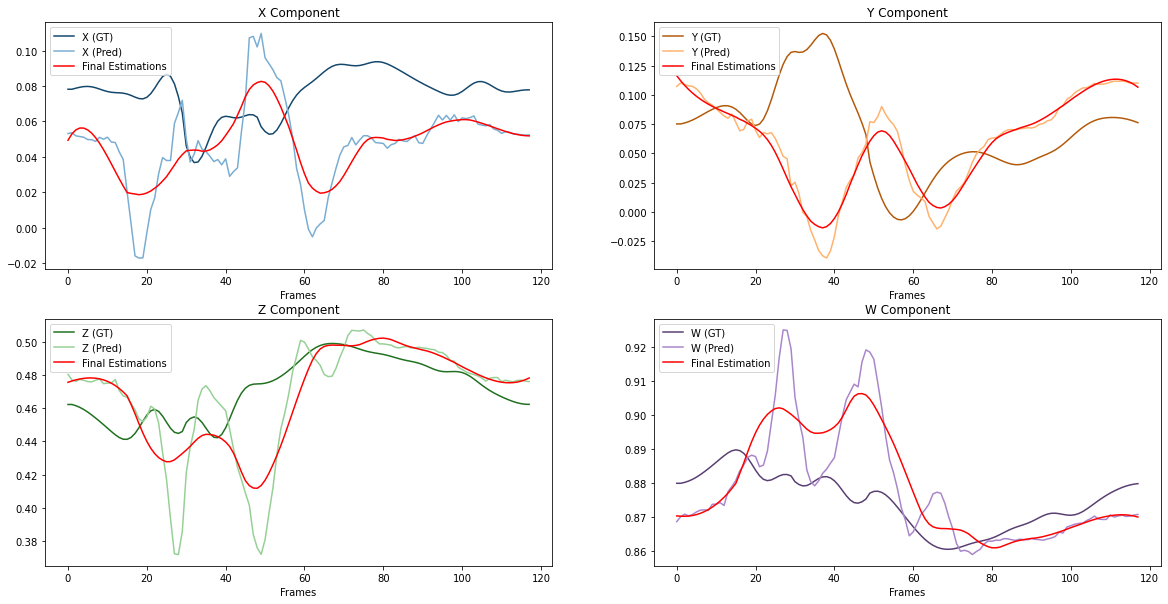

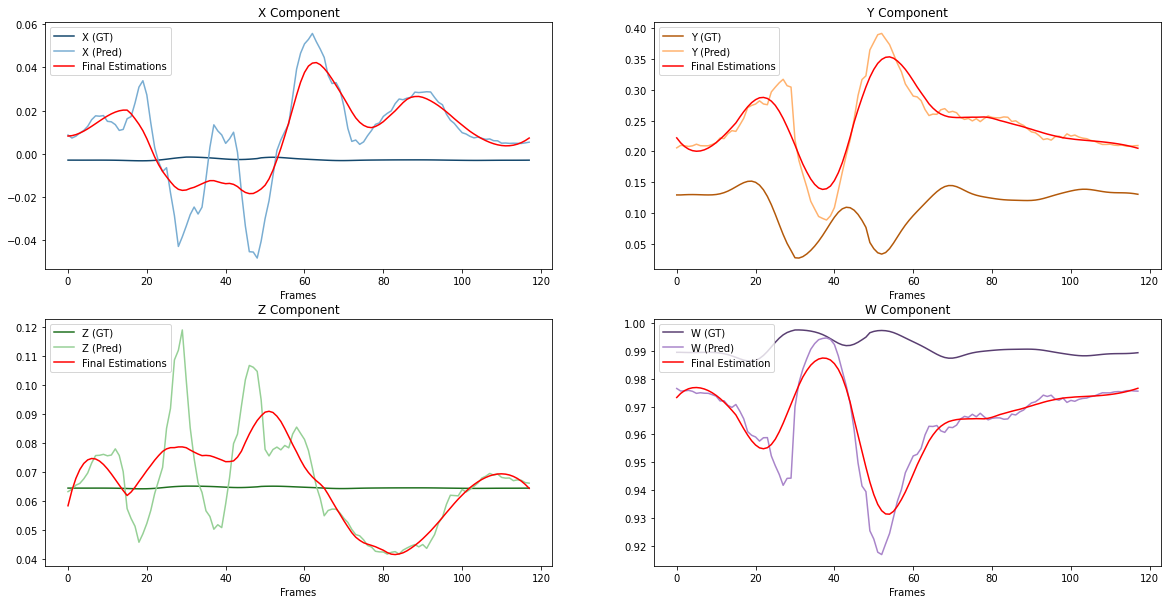

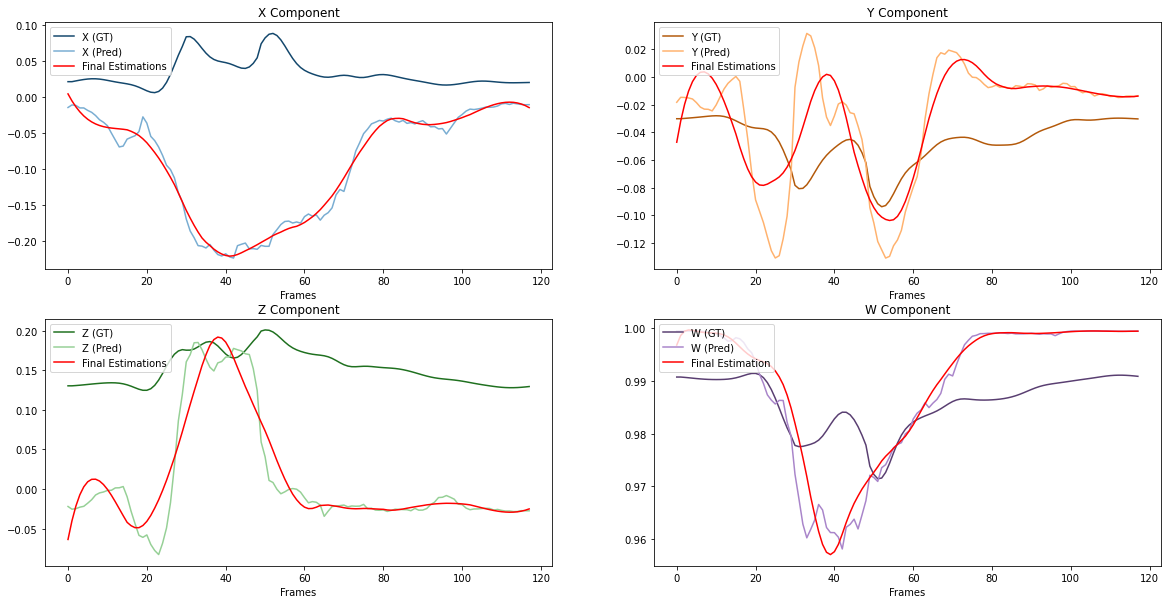

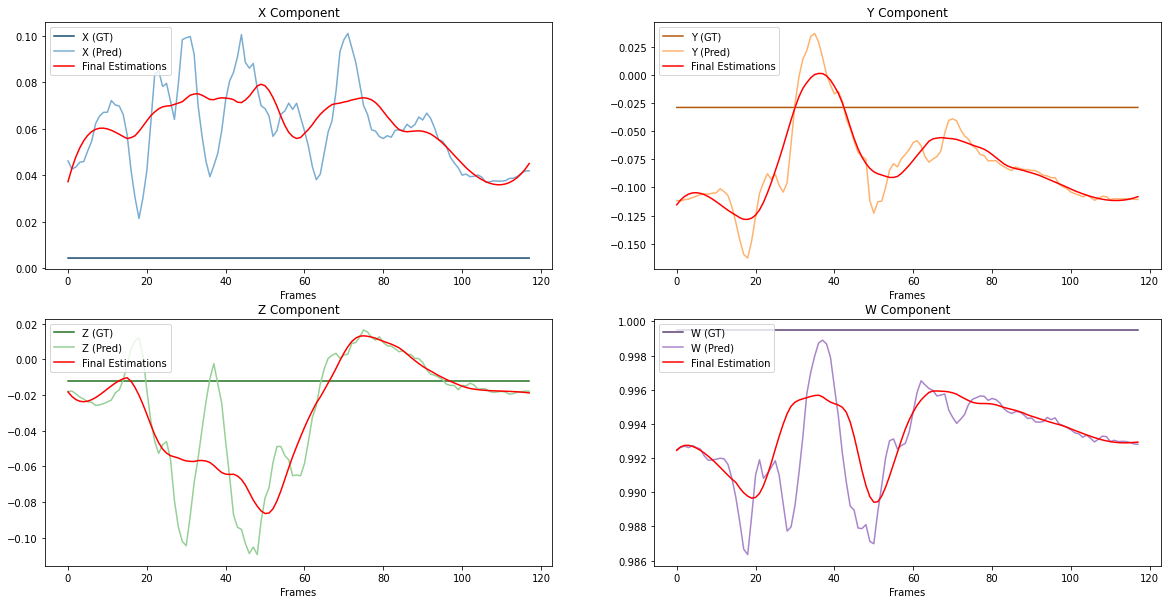

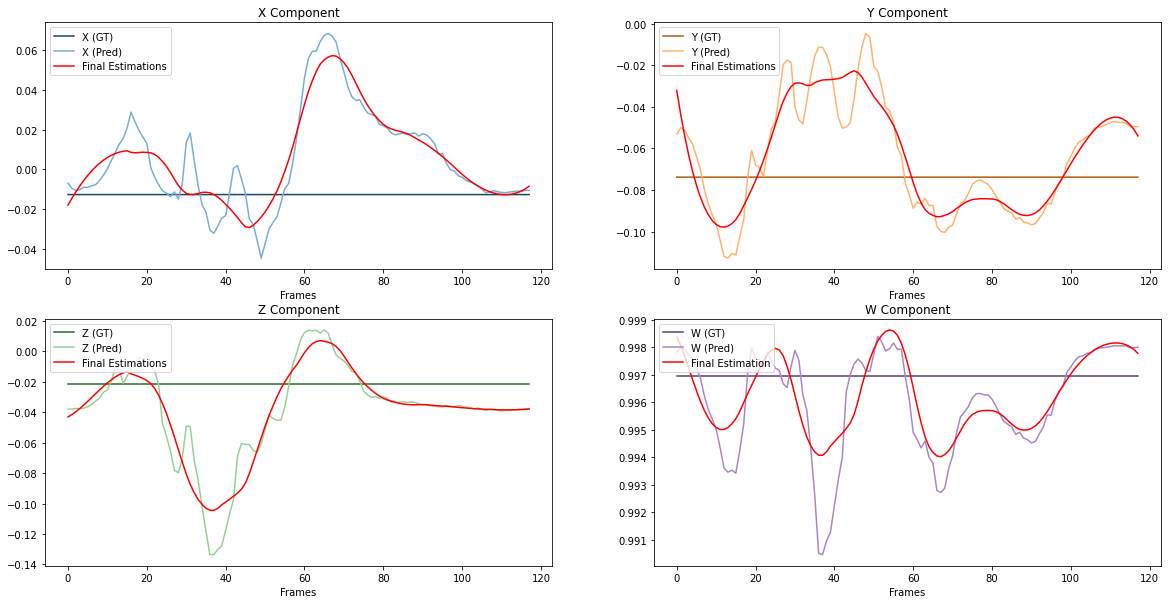

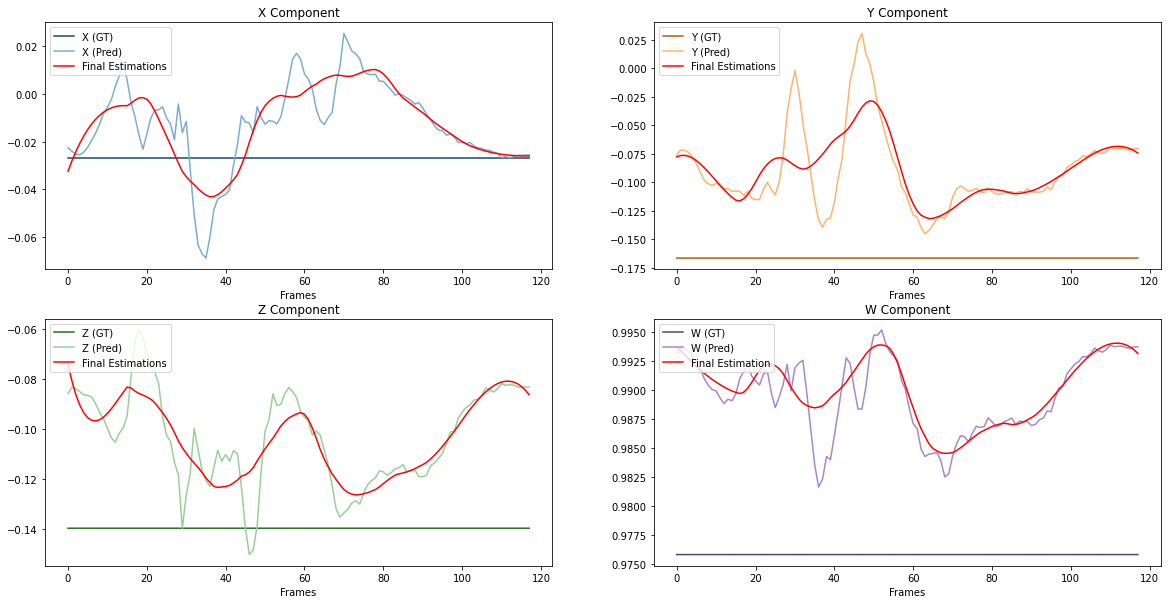

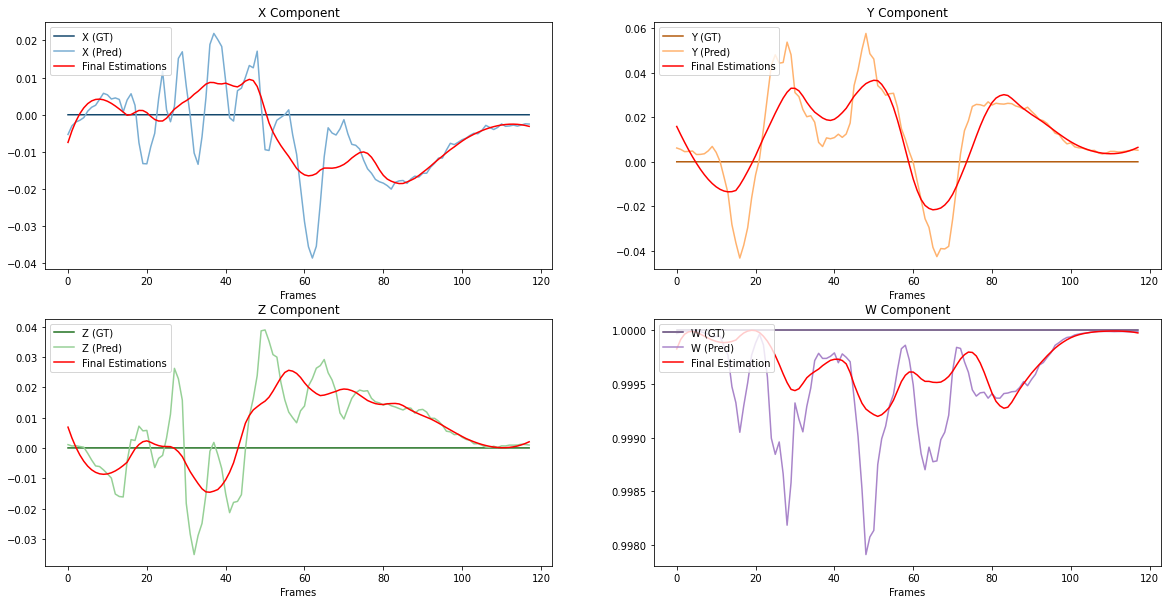

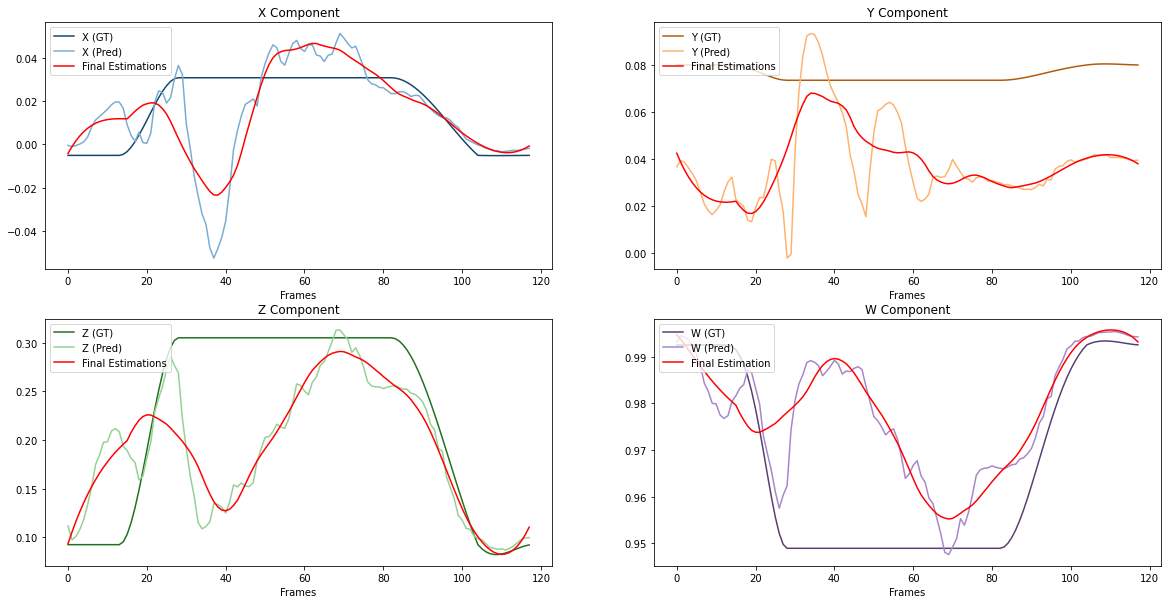

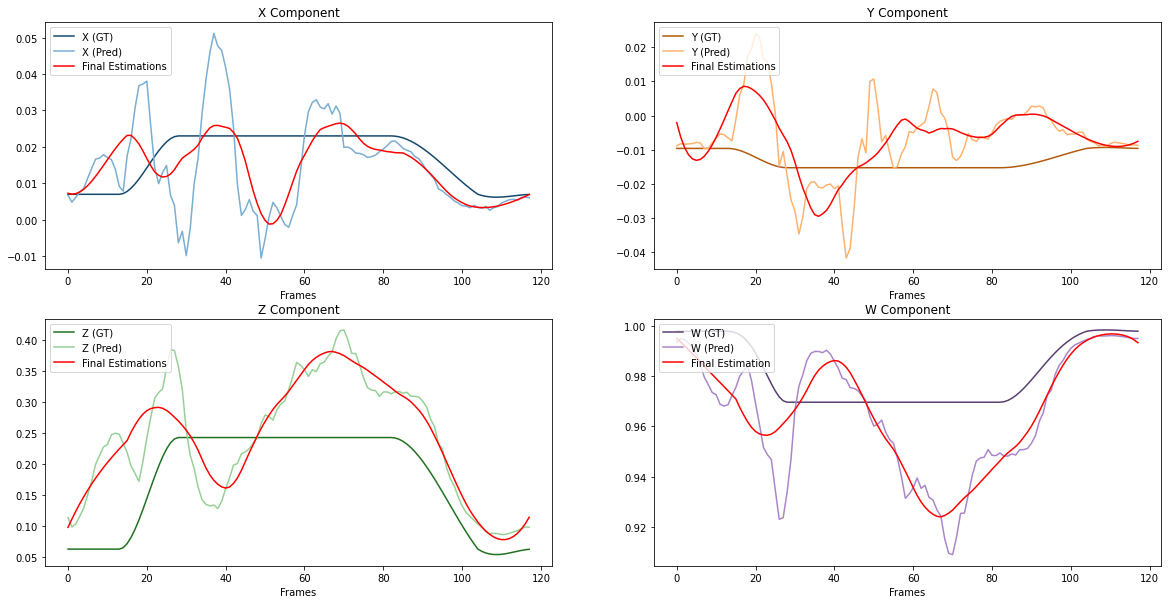

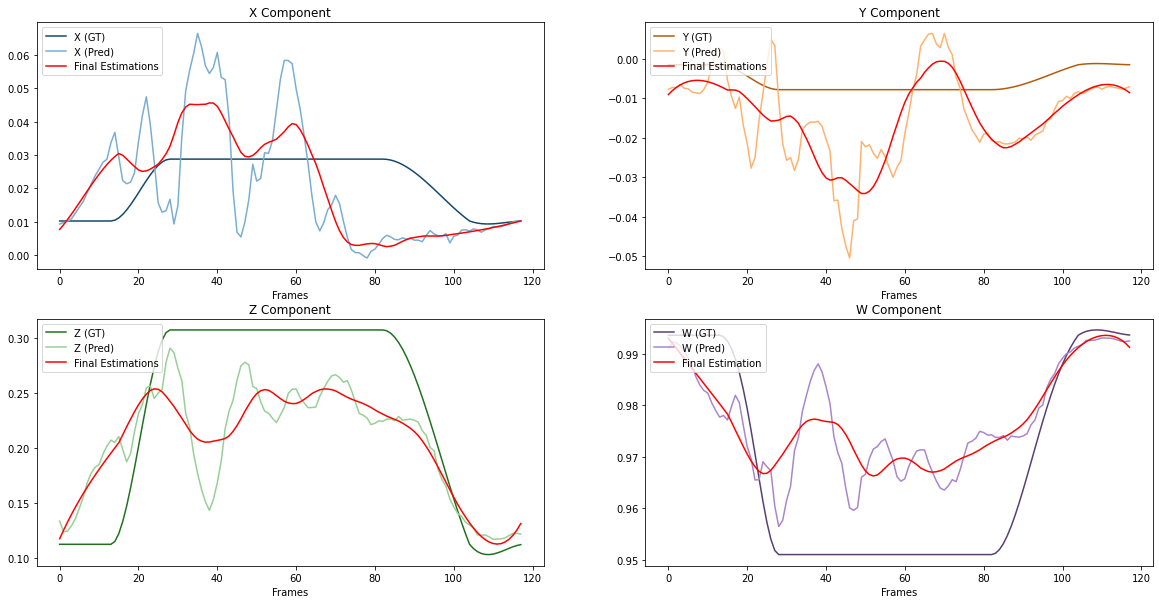

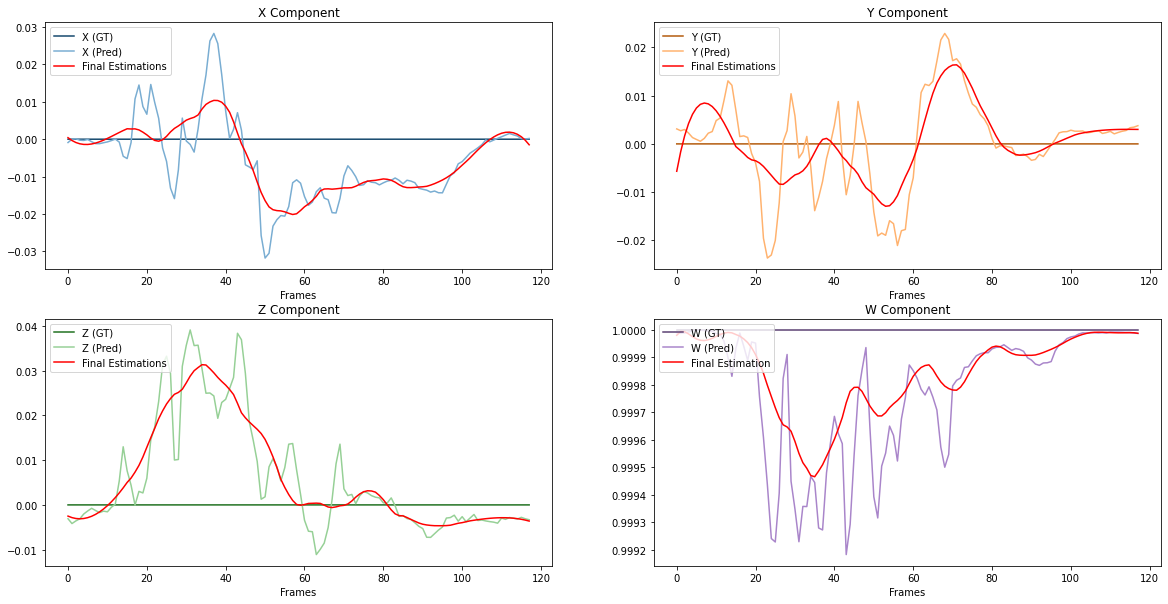

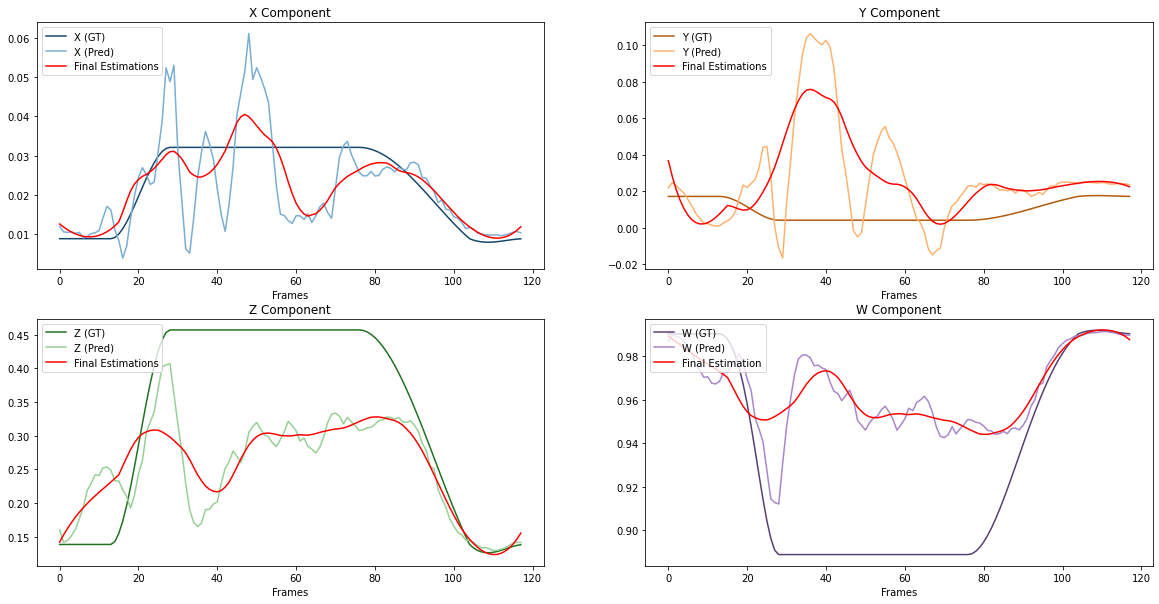

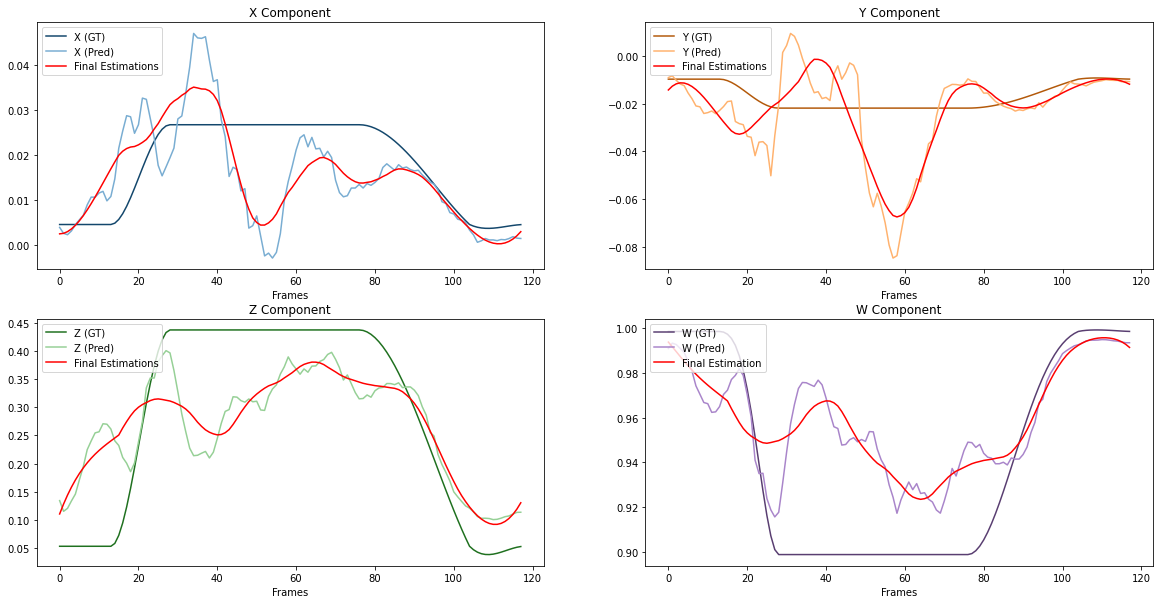

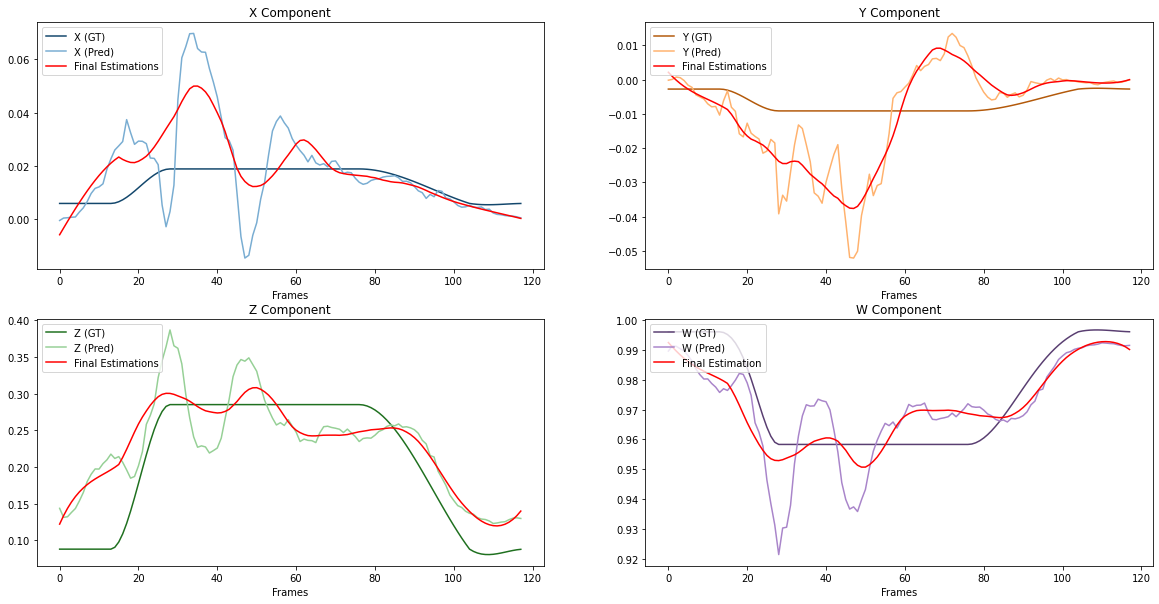

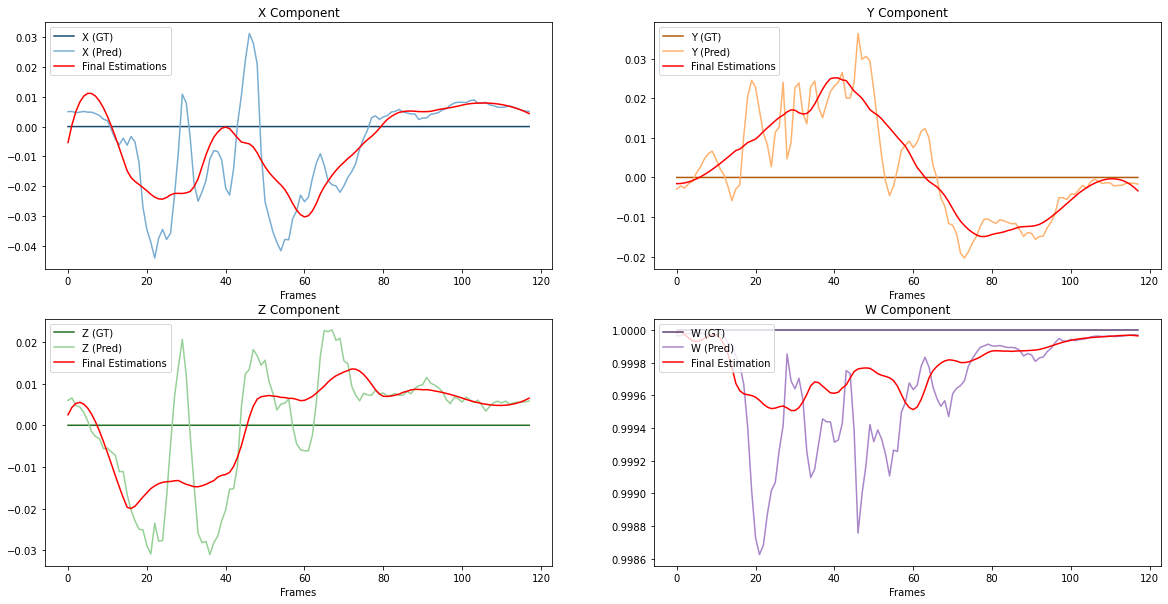

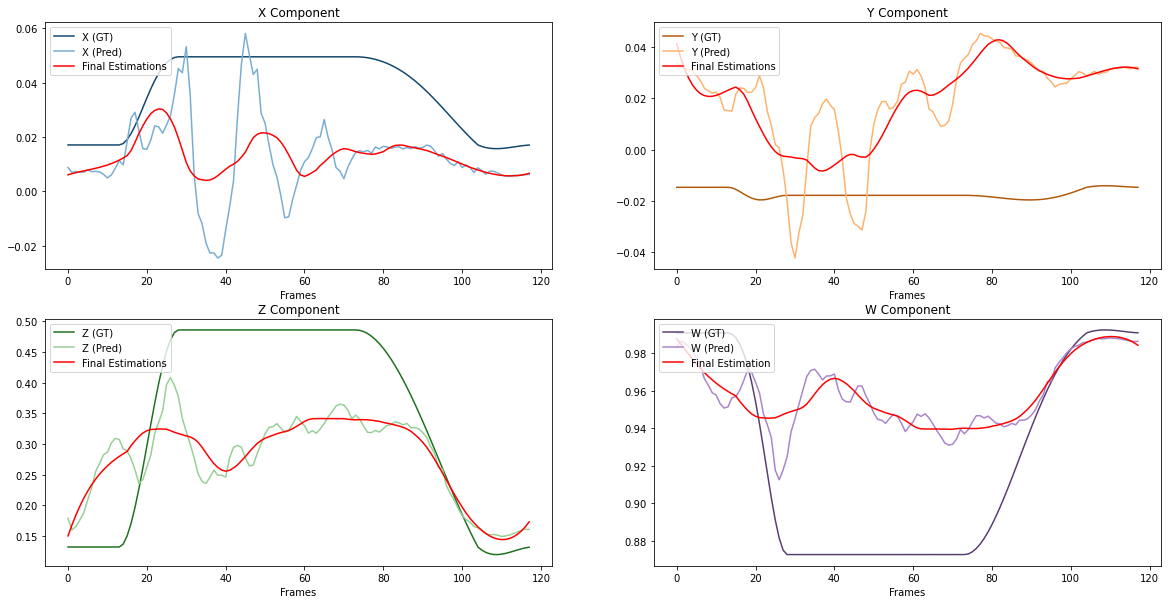

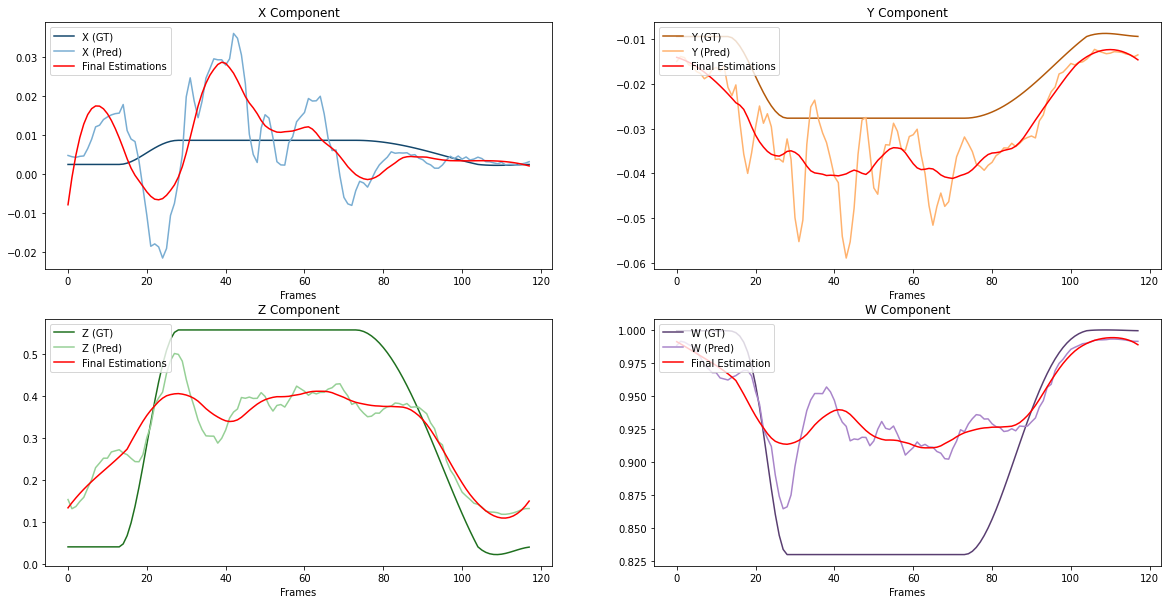

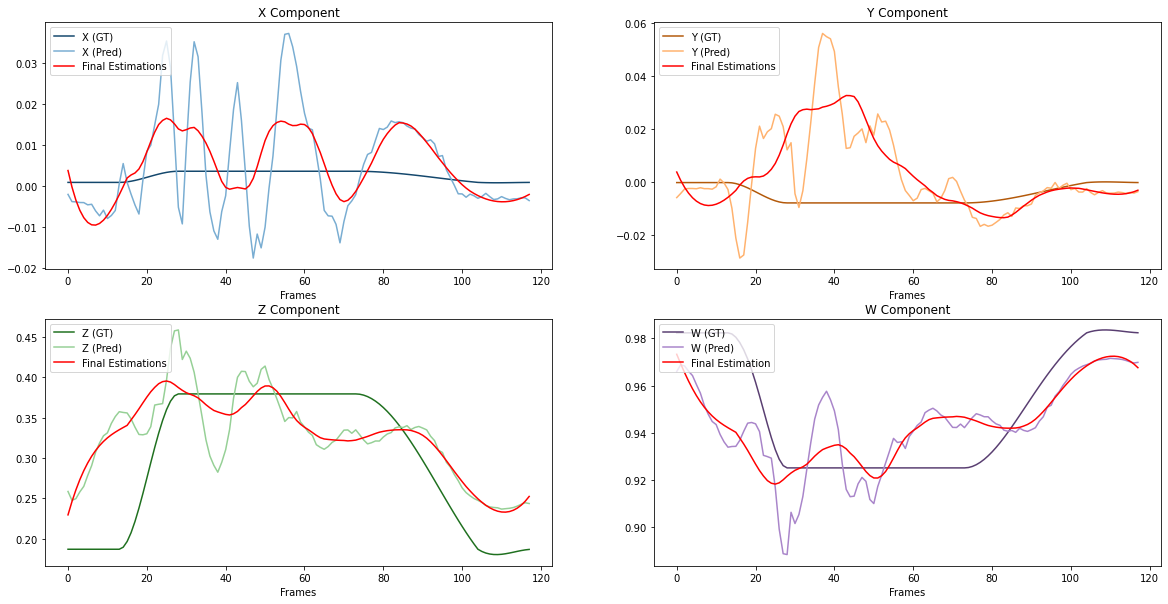

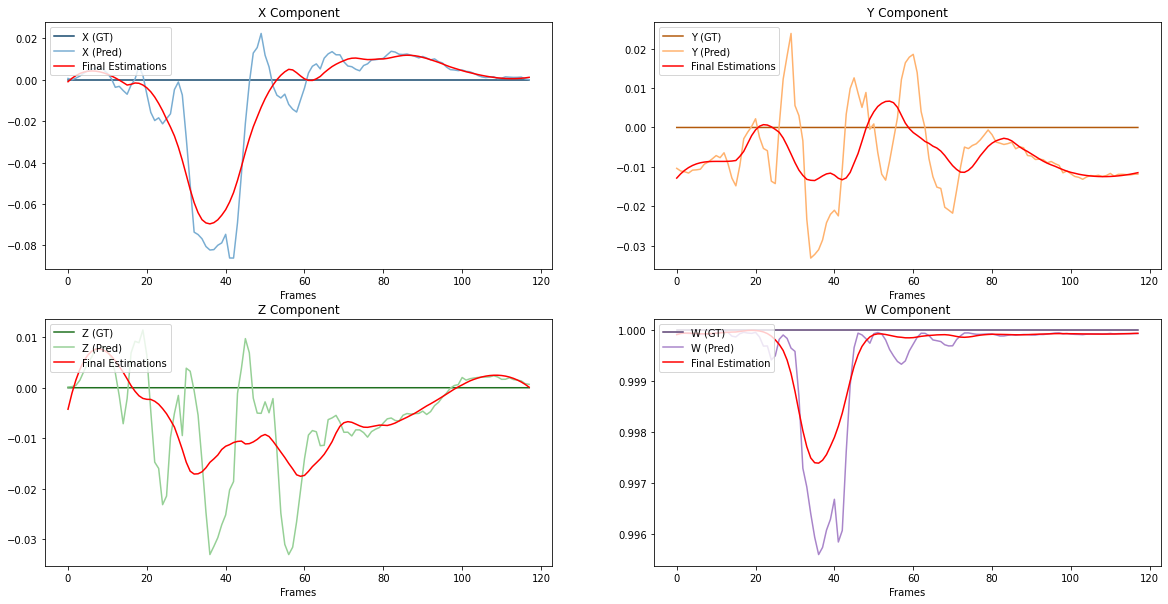

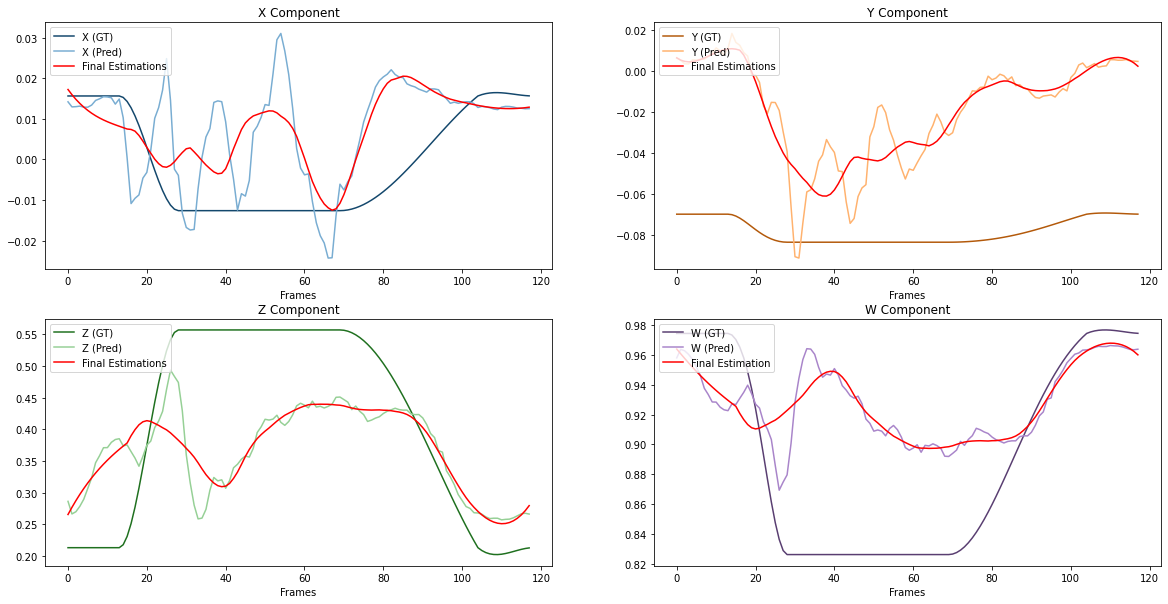

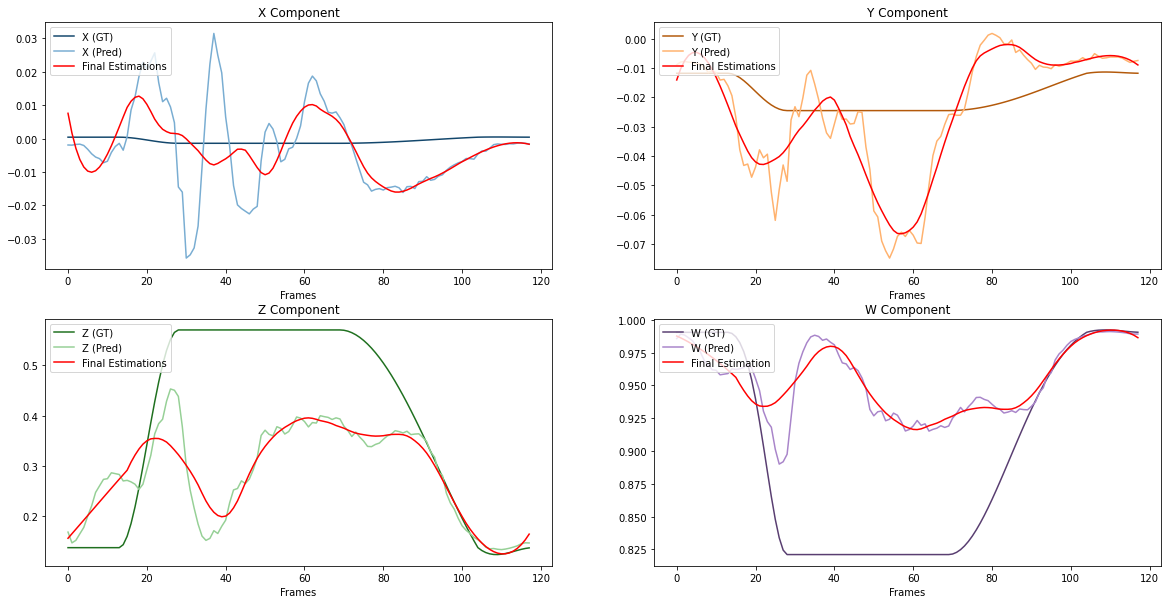

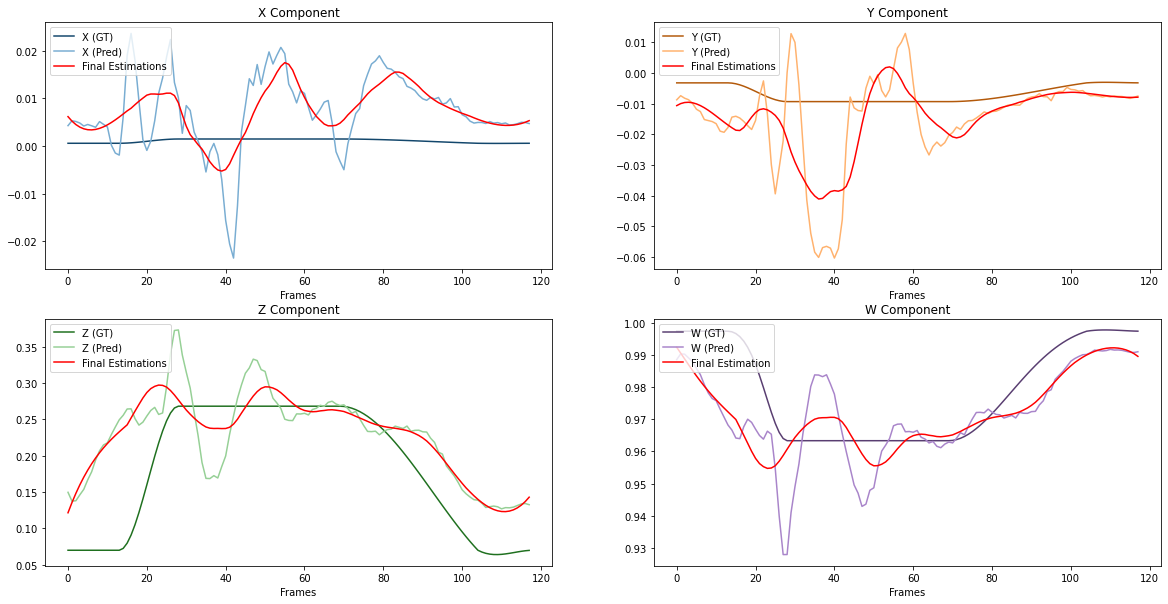

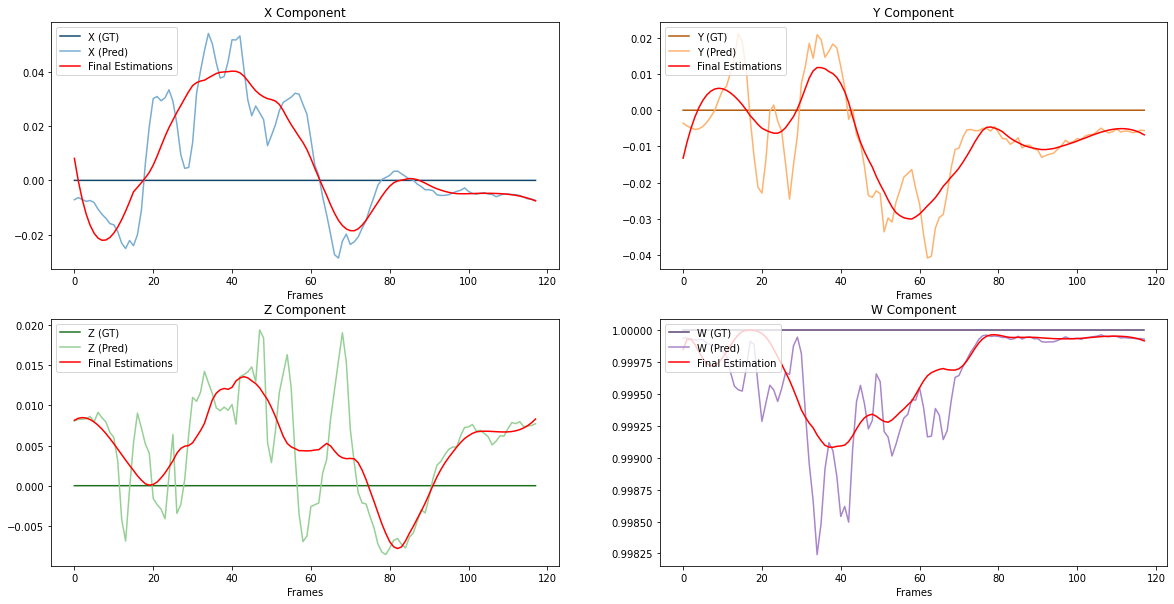

In [85]:
import math
import numpy as np
from itertools import zip_longest
from scipy.signal import savgol_filter

test_data_path = dataset_dir
pred_data_path = project_path + "\Evaluation"
postpo = True # set to False if you don't want any post-processing (normalisation, smooth filer)
flag_plot = True # see quaternions comparison
save_predictions = False
name4plot = "Dwarf Idle (mosquito)" # name of the animation to plot (if not, pycharm runs out of memory) Check your test set of animations
model4predict = model4 # model auxiliar in case we have several trained


list_quats = [
    "Hips",
    "Spine",
    "Spine1",
    "Spine2",
    "Neck",
    "Head",
    "Head_Top",
    "LeftShoulder",
    "LeftArm",
    "LeftForeArm",
    "LeftHand",
    "LeftHandThumb1",
    "LeftHandThumb2",
    "LeftHandThumb3",
    "LeftHandThumb4",
    "LeftHandIndex1",
    "LeftHandIndex2",
    "LeftHandIndex3",
    "LeftHandIndex4",
    "LeftHandMiddle1",
    "LeftHandMiddle2",
    "LeftHandMiddle3",
    "LeftHandMiddle4",
    "LeftHandRing1",
    "LeftHandRing2",
    "LeftHandRing3",
    "LeftHandRing4",
    "LeftHandPinky1",
    "LeftHandPinky2",
    "LeftHandPinky3",
    "LeftHandPinky4",
    "RightShoulder",
    "RightArm",
    "RightForeArm",
    "RightHand",
    "RightHandThumb1",
    "RightHandThumb2",
    "RightHandThumb3",
    "RightHandThumb4",
    "RightHandIndex1",
    "RightHandIndex2",
    "RightHandIndex3",
    "RightHandIndex4",
    "RightHandMiddle1",
    "RightHandMiddle2",
    "RightHandMiddle3",
    "RightHandMiddle4",
    "RightHandRing1",
    "RightHandRing2",
    "RightHandRing3",
    "RightHandRing4",
    "RightHandPinky1",
    "RightHandPinky2",
    "RightHandPinky3",
    "RightHandPinky4",
] # List of all the bones that have quaternions

# From https://automaticaddison.com/how-to-convert-a-quaternion-into-euler-angles-in-python/
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)

        return roll_x, pitch_y, yaw_z # in radians

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

# Do for the Default Test data
os.chdir(os.path.join(test_data_path, "Default\Test"))
for file in os.listdir():
    if file.endswith(".json"):
        # load the data
        with open(file, 'r') as f:
            data_test = json.load(f)
        with open(os.path.join("gt", file), 'r') as f:
            data_testGT = json.load(f)

        # PREDICTION
        data_pred = model4predict.predict(data_test, batch_size=batch_size)

        # Create path to add the figures or the prediction
        if save_predictions or (flag_plot and file[:-5] == name4plot):
            os.makedirs(os.path.join(pred_data_path, file[:-5]), exist_ok=True)

        ## Post-Processing
        # Normalization of the predicted quaternion
        for idx_frame, i in enumerate(data_pred):
            for idx_quat, (x,y,z,w) in enumerate((grouper(4, i))):
                sum = np.sqrt(x*x + y*y + z*z + w*w)
                x /= sum
                y /= sum
                z /= sum
                w /= sum
                data_pred[idx_frame][(idx_quat*4):((idx_quat*4)+4)] = [x,y,z,w]

        if postpo is True:
            data_pred_pp = [[] for x in range(len(data_pred))]
            for i in range(len(data_pred[0])):
                # apply a smooth filter to correct noise
                pp_data = savgol_filter([j[i] for j in data_pred], 31, 3) # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
                [t.append(pp_data[idx]) for (idx, t) in enumerate(data_pred_pp)]

            # quaternion normalization
            for idx_frame, i in enumerate(data_pred_pp):
                for idx_quat, (x,y,z,w) in enumerate((grouper(4, i))):
                    sum = np.sqrt(x*x + y*y + z*z + w*w)
                    x /= sum
                    y /= sum
                    z /= sum
                    w /= sum
                    data_pred_pp[idx_frame][(idx_quat*4):((idx_quat*4)+4)] = [x,y,z,w]

            # Plot to visually see the improvement
            if flag_plot is True and file[:-5] == name4plot:
                for b_idx in range(int(len(data_pred[0]) / 4)): # 220 / 4 = 55 is the number of joints in the array of quaternions
                    f = plt.figure(figsize=(20, 10))
                    xx1 = f.add_subplot(221)
                    xx2 = f.add_subplot(222)
                    xx3 = f.add_subplot(223)
                    xx4 = f.add_subplot(224)

                    # Subplot for the X coordinate
                    xx1.plot([j[b_idx*4+0] for j in data_testGT], color='#13476c') # GT data
                    xx1.plot([j[b_idx*4+0] for j in data_pred], color='#79add2') # Pred data
                    xx1.plot([j[b_idx*4+0] for j in data_pred_pp], color='red') # Post-processed pred data

                    #xx1.title.set_text("Comparison of the Quaternion Curves for the animation <" + file[:-5] + ">")
                    xx1.title.set_text("X Component")
                    #xx1.set_ylabel("Quaternion Values X of Joint <" + list_quats[b_idx] + ">")
                    xx1.set_xlabel("Frames")
                    xx1.legend(["X (GT)", "X (Pred)", "Final Estimations"], loc="upper left")
                    #xx1.set_ylim([-1, 1])

                    # Subplot for the Y coordinate
                    xx2.plot([j[b_idx*4+1] for j in data_testGT], color='#b3590a')
                    xx2.plot([j[b_idx*4+1] for j in data_pred], color='#ffb26e')
                    xx2.plot([j[b_idx*4+1] for j in data_pred_pp], color='red')

                    #xx2.title.set_text("Comparison of the Quaternion Curves for the animation <" + file[:-5] + ">")
                    xx2.title.set_text("Y Component")
                    #xx2.set_ylabel("Quaternion Values Y of Joint <" + list_quats[b_idx] + ">")
                    xx2.set_xlabel("Frames")
                    xx2.legend(["Y (GT)", "Y (Pred)", "Final Estimations"], loc="upper left")
                    #xx2.set_ylim([-1, 1])

                    # Subplot for the Z coordinate
                    xx3.plot([j[b_idx*4+2] for j in data_testGT], color='#1f701f')
                    xx3.plot([j[b_idx*4+2] for j in data_pred], color='#96d096')
                    xx3.plot([j[b_idx*4+2] for j in data_pred_pp], color='red')

                    #xx3.title.set_text("Comparison of the Quaternion Curves for the animation <" + file[:-5] + ">")
                    xx3.title.set_text("Z Component")
                    #xx3.set_ylabel("Quaternion Values Z of Joint <" + list_quats[b_idx] + ">")
                    xx3.set_xlabel("Frames")
                    xx3.legend(["Z (GT)", "Z (Pred)", "Final Estimations"], loc="upper left")
                    #xx3.set_ylim([-1, 1])

                    # Subplot for the W coordinate
                    xx4.plot([j[b_idx*4+3] for j in data_testGT], color='#593e71')
                    xx4.plot([j[b_idx*4+3] for j in data_pred], color='#a985ca')
                    xx4.plot([j[b_idx*4+3] for j in data_pred_pp], color='red')

                    #xx4.title.set_text("Comparison of the Quaternion Curves for the animation <" + file[:-5] + ">")
                    xx4.title.set_text("W Component")
                    #xx4.set_ylabel("Quaternion Values W of Joint <" + list_quats[b_idx] + ">")
                    xx4.set_xlabel("Frames")
                    xx4.legend(["W (GT)", "W (Pred)", "Final Estimation"], loc="upper left")
                    #xx4.set_ylim([0, 1])

                    f.savefig(os.path.join(pred_data_path, file[:-5], file[:-5] + "_" + list_quats[b_idx] + '.pdf'), bbox_inches='tight')
                    plt.show()

            # Use the computed post processed values
            aux_list = np.array(data_pred_pp)
            data_pred = aux_list

        # Save the predicted values
        if save_predictions:
            with open(os.path.join(pred_data_path, file[:-5], "Prediction.json"), 'w') as f:
                json.dump(data_pred.tolist(), f, indent=4)

            ## Quaternions error
            count = 0
            n = int(len(data_testGT[0]) / 4)
            eval_angles = [[] for x in range(n)] # list of the error angles per bone at all frames
            for (frame, frame_gt) in zip(data_pred, data_testGT):
                frame_angles = [] # init
                for (x,y,z,w), (X,Y,Z,W) in zip(grouper(4, frame), grouper(4, frame_gt)):
                    roll, pitch, yaw = euler_from_quaternion(x, y, z, w)
                    roll_gt, pitch_gt, yaw_gt = euler_from_quaternion(X, Y, Z, W)
                    # compare with GT
                    # we don't check cases like 360 vs 0 because it would increase the computational time, and it is never the case
                    # if the error of angles exceeds 180 degrees maybe we should implement it
                    roll_err = abs(np.rad2deg(roll - roll_gt))
                    pitch_err = abs(np.rad2deg(pitch - pitch_gt))
                    yaw_err = abs(np.rad2deg(yaw - yaw_gt))
                    # add to the lists
                    eval_angles[count].append([roll_err, pitch_err, yaw_err])
                    count += 1
                count = 0 # reset bone idx

            # Store the evaluation results
            with open(os.path.join(pred_data_path, file[:-5], "EvaluationAngles.json"), 'w') as f:
                json.dump(eval_angles, f, indent=4)

# Repeat for the Mirror Test data
os.chdir(os.path.join(test_data_path, "Mirror\Test"))
for file in os.listdir():
    if file.endswith(".json"):
        # load the data
        with open(file, 'r') as f:
            data_test = json.load(f)
        with open(os.path.join("gt", file), 'r') as f:
            data_testGT = json.load(f)

        # PREDICTION
        data_pred = model4predict.predict(data_test, batch_size=batch_size)

        ## Post-Processing
        # Normalization of the predicted quaternion
        for idx_frame, i in enumerate(data_pred):
            for idx_quat, (x,y,z,w) in enumerate((grouper(4, i))):
                sum = np.sqrt(x*x + y*y + z*z + w*w)
                x /= sum
                y /= sum
                z /= sum
                w /= sum
                data_pred[idx_frame][(idx_quat*4):((idx_quat*4)+4)] = [x,y,z,w]

        if postpo is True:
            data_pred_pp = [[] for x in range(len(data_pred))]
            for i in range(len(data_pred[0])):
                # apply a smooth filter to correct noise
                pp_data = savgol_filter([j[i] for j in data_pred], 31, 3)
                [t.append(pp_data[idx]) for (idx, t) in enumerate(data_pred_pp)]

            # quaternion normalization
            for idx_frame, i in enumerate(data_pred_pp):
                for idx_quat, (x,y,z,w) in enumerate((grouper(4, i))):
                    sum = np.sqrt(x*x + y*y + z*z + w*w)
                    x /= sum
                    y /= sum
                    z /= sum
                    w /= sum
                    data_pred_pp[idx_frame][(idx_quat*4):((idx_quat*4)+4)] = [x,y,z,w]

            # Use the computed post processed values
            aux_list = np.array(data_pred_pp)
            data_pred = aux_list

        # Save the predicted values
        if save_predictions:
            os.makedirs(os.path.join(pred_data_path, "_Mirror_ " + file[:-5]), exist_ok=True)
            with open(os.path.join(pred_data_path, "_Mirror_ " + file[:-5], "Prediction.json"), 'w') as f:
                json.dump(data_pred.tolist(), f, indent=4)

            ## Quaternions error
            count = 0
            n = int(len(data_testGT[0]) / 4)
            eval_angles = [[] for x in range(n)] # list of the error angles per bone at all frames
            for (frame, frame_gt) in zip(data_pred, data_testGT):
                frame_angles = [] # init
                for (x,y,z,w), (X,Y,Z,W) in zip(grouper(4, frame), grouper(4, frame_gt)):
                    roll, pitch, yaw = euler_from_quaternion(x, y, z, w)
                    roll_gt, pitch_gt, yaw_gt = euler_from_quaternion(X, Y, Z, W)
                    # compare with GT
                    roll_err = abs(np.rad2deg(roll - roll_gt))
                    pitch_err = abs(np.rad2deg(pitch - pitch_gt))
                    yaw_err = abs(np.rad2deg(yaw - yaw_gt))
                    # add to the lists
                    eval_angles[count].append([roll_err, pitch_err, yaw_err])
                    count += 1
                count = 0 # reset bone idx

            # Store the evaluation results
            with open(os.path.join(pred_data_path, "_Mirror_ " + file[:-5], "EvaluationAngles.json"), 'w') as f:
                json.dump(eval_angles, f, indent=4)


Evaluation of the predictions

In [84]:
#eval_data_path = project_path + "\Experiments\\for presentation\\test 3"
eval_data_path = project_path + "\Evaluation\Split 2\model 4"

# Plot of the errors per bone
bone_list = [
    "mixamorigHips",
    "mixamorigSpine",
    "mixamorigSpine1",
    "mixamorigSpine2",
    "mixamorigNeck",
    "mixamorigHead",
    "mixamorigHead_Top",
    "ENDSITE",
    "mixamorigLeftShoulder",
    "mixamorigLeftArm",
    "mixamorigLeftForeArm",
    "mixamorigLeftHand",
    "mixamorigLeftHandThumb1",
    "mixamorigLeftHandThumb2",
    "mixamorigLeftHandThumb3",
    "mixamorigLeftHandThumb4",
    "ENDSITE",
    "mixamorigLeftHandIndex1",
    "mixamorigLeftHandIndex2",
    "mixamorigLeftHandIndex3",
    "mixamorigLeftHandIndex4",
    "ENDSITE",
    "mixamorigLeftHandMiddle1",
    "mixamorigLeftHandMiddle2",
    "mixamorigLeftHandMiddle3",
    "mixamorigLeftHandMiddle4",
    "ENDSITE",
    "mixamorigLeftHandRing1",
    "mixamorigLeftHandRing2",
    "mixamorigLeftHandRing3",
    "mixamorigLeftHandRing4",
    "ENDSITE",
    "mixamorigLeftHandPinky1",
    "mixamorigLeftHandPinky2",
    "mixamorigLeftHandPinky3",
    "mixamorigLeftHandPinky4",
    "ENDSITE",
    "mixamorigRightShoulder",
    "mixamorigRightArm",
    "mixamorigRightForeArm",
    "mixamorigRightHand",
    "mixamorigRightHandThumb1",
    "mixamorigRightHandThumb2",
    "mixamorigRightHandThumb3",
    "mixamorigRightHandThumb4",
    "ENDSITE",
    "mixamorigRightHandIndex1",
    "mixamorigRightHandIndex2",
    "mixamorigRightHandIndex3",
    "mixamorigRightHandIndex4",
    "ENDSITE",
    "mixamorigRightHandMiddle1",
    "mixamorigRightHandMiddle2",
    "mixamorigRightHandMiddle3",
    "mixamorigRightHandMiddle4",
    "ENDSITE",
    "mixamorigRightHandRing1",
    "mixamorigRightHandRing2",
    "mixamorigRightHandRing3",
    "mixamorigRightHandRing4",
    "ENDSITE",
    "mixamorigRightHandPinky1",
    "mixamorigRightHandPinky2",
    "mixamorigRightHandPinky3",
    "mixamorigRightHandPinky4",
    "ENDSITE",
    "mixamorigLeftUpLeg",
    "mixamorigLeftLeg",
    "mixamorigLeftFoot",
    "mixamorigLeftToeBase",
    "mixamorigLeftToe_End",
    "ENDSITE",
    "mixamorigRightUpLeg",
    "mixamorigRightLeg",
    "mixamorigRightFoot",
    "mixamorigRightToeBase",
    "mixamorigRightToe_End",
    "ENDSITE"
] # List of all the bones
bone_list_quats = [
    "mixamorigHips",
    "mixamorigSpine",
    "mixamorigSpine1",
    "mixamorigSpine2",
    "mixamorigNeck",
    "mixamorigHead",
    "mixamorigHead_Top",
    "mixamorigLeftShoulder",
    "mixamorigLeftArm",
    "mixamorigLeftForeArm",
    "mixamorigLeftHand",
    "mixamorigLeftHandThumb1",
    "mixamorigLeftHandThumb2",
    "mixamorigLeftHandThumb3",
    "mixamorigLeftHandThumb4",
    "mixamorigLeftHandIndex1",
    "mixamorigLeftHandIndex2",
    "mixamorigLeftHandIndex3",
    "mixamorigLeftHandIndex4",
    "mixamorigLeftHandMiddle1",
    "mixamorigLeftHandMiddle2",
    "mixamorigLeftHandMiddle3",
    "mixamorigLeftHandMiddle4",
    "mixamorigLeftHandRing1",
    "mixamorigLeftHandRing2",
    "mixamorigLeftHandRing3",
    "mixamorigLeftHandRing4",
    "mixamorigLeftHandPinky1",
    "mixamorigLeftHandPinky2",
    "mixamorigLeftHandPinky3",
    "mixamorigLeftHandPinky4",
    "mixamorigRightShoulder",
    "mixamorigRightArm",
    "mixamorigRightForeArm",
    "mixamorigRightHand",
    "mixamorigRightHandThumb1",
    "mixamorigRightHandThumb2",
    "mixamorigRightHandThumb3",
    "mixamorigRightHandThumb4",
    "mixamorigRightHandIndex1",
    "mixamorigRightHandIndex2",
    "mixamorigRightHandIndex3",
    "mixamorigRightHandIndex4",
    "mixamorigRightHandMiddle1",
    "mixamorigRightHandMiddle2",
    "mixamorigRightHandMiddle3",
    "mixamorigRightHandMiddle4",
    "mixamorigRightHandRing1",
    "mixamorigRightHandRing2",
    "mixamorigRightHandRing3",
    "mixamorigRightHandRing4",
    "mixamorigRightHandPinky1",
    "mixamorigRightHandPinky2",
    "mixamorigRightHandPinky3",
    "mixamorigRightHandPinky4",
] # List of all the bones that have quaternions

os.chdir(eval_data_path)
for file in os.listdir():
    # Load the data
    if not os.path.isfile(os.path.join(eval_data_path, file, "EvaluationDistances.json")):
        continue
    with open(os.path.join(eval_data_path, file, "EvaluationDistances.json"), "r") as f:
        eval_dist = json.load(f)
    with open(os.path.join(eval_data_path, file, "EvaluationPositions.json"), "r") as f:
        eval_pos = json.load(f)
    with open(os.path.join(eval_data_path, file, "EvaluationAngles.json"), "r") as f:
        eval_ang = json.load(f)

    for bone in bone_list_quats:
        #print(bone[9:])

        # Find the index with respect to the selected bone to evaluate
        idx = bone_list.index(bone)
        idx2 = bone_list_quats.index(bone)
        b_to_evaluate = bone[9:] # remove "mixamorig" tag
        bone_positions = eval_pos[idx]
        bone_angles = eval_ang[idx2]

        ### Positions error
        fig_pos = plt.figure(figsize=(20, 5))
        bx = fig_pos.add_subplot(131)
        by = fig_pos.add_subplot(132)
        bz = fig_pos.add_subplot(133)

        # Summarize history for accuracy
        bx.plot(bone_positions[0][0])
        bx.plot(bone_positions[1][0])
        bx.locator_params(nbins=4)
        bx.title.set_text(b_to_evaluate + " - X axis")
        bx.set_ylabel("Centimeters")
        bx.set_xlabel("Frames")
        bx.legend(["Ground Truth", "Prediction"], loc="upper left")

        # Summarize history for loss
        by.plot(bone_positions[0][1])
        by.plot(bone_positions[1][1])
        by.locator_params(nbins=4)
        by.title.set_text(b_to_evaluate + " - Y axis")
        by.set_ylabel("Centimeters")
        by.set_xlabel("Frames")
        by.legend(["Ground Truth", "Prediction"], loc="upper left")

        # Summarize history for loss
        bz.plot(bone_positions[0][2])
        bz.plot(bone_positions[1][2])
        bz.locator_params(nbins=4)
        bz.title.set_text(b_to_evaluate + " - Z axis")
        bz.set_ylabel("Centimeters")
        bz.set_xlabel("Frames")
        bz.legend(["Ground Truth", "Prediction"], loc="upper left")

        #plt.show()
        fig_pos.savefig(os.path.join(file, b_to_evaluate + "_Positions.pdf"), bbox_inches='tight')
        plt.close()

        ### Distance error
        fig_dist = plt.figure(figsize=(20, 5))
        dx = fig_dist.add_subplot(1,1,1)
        dx.plot(eval_dist[idx])
        dx.title.set_text("Error distance between ground truth and prediction <" + b_to_evaluate + "> joint")
        dx.set_ylabel("Centimeters")
        dx.set_xlabel("Frames")

        sum_err = np.sum(eval_dist[idx])
        print(file + " <" + b_to_evaluate + "> MIN err dist %.3f " % min(eval_dist[idx]) + "cm  || MAX err dist %.3f " % max(eval_dist[idx]) +
              "cm  || MEAN err dist %.3f " % (sum_err/len(eval_dist[idx])) + "cm  || TOTAL err dist %.3f " % sum_err + "cm")
        #print(file + " - Maximum error distance for <" + b_to_evaluate + "> is %.3f " % max(eval_dist[idx]) + "cm")
        #print(file + " - Mean error distance for    <" + b_to_evaluate + "> is %.3f " % (sum_err/len(eval_dist[idx])) + "cm")
        #print(file + " - Total error distance for   <" + b_to_evaluate + "> is %.3f " % sum_err + "cm")

        #plt.show()
        fig_dist.savefig(os.path.join(file, b_to_evaluate + "_Distances.pdf"), bbox_inches='tight')
        plt.close()

        ### Angle error
        fig_ang = plt.figure(figsize=(20, 5))
        ax = fig_ang.add_subplot(1,1,1)
        ax.plot([item[0] for item in bone_angles])
        ax.plot([item[1] for item in bone_angles])
        ax.plot([item[2] for item in bone_angles])
        ax.title.set_text("Error angle between ground truth and prediction <" + b_to_evaluate + "> joint")
        ax.set_ylabel("Degrees")
        ax.set_xlabel("Frames")
        ax.legend(["yaw", "pitch", "roll"], loc="upper left")

        #plt.show()
        fig_ang.savefig(os.path.join(file, b_to_evaluate + "_Angles.pdf"), bbox_inches='tight')
        plt.close()

Dwarf Idle (mosquito) <Hips> MIN err dist 0.000 cm  || MAX err dist 0.000 cm  || MEAN err dist 0.000 cm  || TOTAL err dist 0.000 cm
Dwarf Idle (mosquito) <Spine> MIN err dist 0.457 cm  || MAX err dist 1.442 cm  || MEAN err dist 0.802 cm  || TOTAL err dist 94.663 cm
Dwarf Idle (mosquito) <Spine1> MIN err dist 1.230 cm  || MAX err dist 4.239 cm  || MEAN err dist 2.350 cm  || TOTAL err dist 277.256 cm
Dwarf Idle (mosquito) <Spine2> MIN err dist 1.445 cm  || MAX err dist 8.747 cm  || MEAN err dist 4.072 cm  || TOTAL err dist 480.481 cm
Dwarf Idle (mosquito) <Neck> MIN err dist 0.832 cm  || MAX err dist 14.544 cm  || MEAN err dist 5.911 cm  || TOTAL err dist 697.505 cm
Dwarf Idle (mosquito) <Head> MIN err dist 0.422 cm  || MAX err dist 16.685 cm  || MEAN err dist 6.732 cm  || TOTAL err dist 794.415 cm
Dwarf Idle (mosquito) <Head_Top> MIN err dist 1.870 cm  || MAX err dist 23.385 cm  || MEAN err dist 8.920 cm  || TOTAL err dist 1052.502 cm
Dwarf Idle (mosquito) <LeftShoulder> MIN err dist 1.


(Run only once) Divide the data in train/val/test. Use the same division for training experiments for consistency

In [10]:
import os
import random
import shutil

folder_path = "E:\Documents\Projects\Python\PycharmCurrent\Dataset\Default"

# Always tha same division, it makes easier the evaluation)
def split_data(folder_path, train_size, test_size, val_size):
    prev_dir = os.getcwd() # get previous dir
    os.chdir(folder_path) # go to the folder dir

    # get length of files in folder
    file_paths = os.listdir()
    [file_paths.remove(f) for f in file_paths if ".json" not in f] # remove unnecessary files (gt folder)
    data_len = len(file_paths)

    # compute the percentages
    tr_size = round(data_len * train_size)
    te_size = round(data_len * test_size)
    v_size = data_len - tr_size - te_size

    random.shuffle(file_paths) # shuffle the list of files

    # loop of copying files into directory train
    os.makedirs("Train", exist_ok=True)
    os.makedirs("Test", exist_ok=True)
    os.makedirs("Validation", exist_ok=True)
    os.makedirs("Train\gt", exist_ok=True)
    os.makedirs("Test\gt", exist_ok=True)
    os.makedirs("Validation\gt", exist_ok=True)
    for (idx, f) in enumerate(file_paths):
        if idx < tr_size:
            shutil.copy(f, os.path.join("Train", f))
            shutil.copy(os.path.join("gt", f), os.path.join("Train\gt", f))
        elif idx < (tr_size + te_size):
            shutil.copy(f, os.path.join("Test", f))
            shutil.copy(os.path.join("gt", f), os.path.join("Test\gt", f))
        else:
            shutil.copy(f, os.path.join("Validation", f))
            shutil.copy(os.path.join("gt", f), os.path.join("Validation\gt", f))
    os.chdir(prev_dir) # return to initial dir

split_data(folder_path, train_size=0.7, test_size=0.1, val_size=0.2)
print("Dataset splitted withouth any problem")

Dataset splitted withouth any problem
